In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import anndata

fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20210310.h5ad'
adata = anndata.read_h5ad(fn_h5ad)
adata = adata[adata.obs['cell_quality'] == 'high']

adata.obs['dataset'] = adata.obs['platform'].replace({
    '10X': 'child',
    'plate': 'adult'
})
adata.obs['sick'] = adata.obs['Condition'].replace({
    'S_dengue': 'sick',
    'dengue': 'sick',
    'DWS': 'sick'
})
sc.pp.normalize_total(adata, target_sum=1e6) #normalize data to CPM (counts per million)
sc.pp.log1p(adata)
#'Age'：共16个病人，11个儿童，5个成年人
#'Condition'：S_dengue,dengue,Healthy,DWS
#'cell_subtype'：unknown, naive_B, CD14+CD16-mono, CD4-CD8+t, memory_B, CD16+CD14+mono, CD4+CD8-t, CD14-CD16+mono, CD4+CD8+t
#'cell_type'：NK_cells, B_cells, T_cells, Monocytes, Plasmablasts, pDCs, cDCs

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


In [2]:
adata_children = adata[adata.obs['dataset'] == 'child']
adata_adults = adata[adata.obs['dataset'] == 'adult']

conditions = list(adata.obs['Condition'].astype('category').cat.categories)
datasets = list(adata.obs['dataset'].astype('category').cat.categories)
sicks = list(adata.obs['sick'].astype('category').cat.categories)
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']

from collections import defaultdict
adata_dic = {}

for dataset in datasets:                                                                                                                          
    for condition in conditions:
        adata_dic[(condition, dataset)] = adata[adata.obs['Condition'] == condition][adata[adata.obs['Condition'] == condition].obs['dataset'] == dataset]
    for sick in sicks:
        adata_dic[(sick, dataset)] = adata[adata.obs['sick'] == sick][adata[adata.obs['sick'] == sick].obs['dataset'] == dataset]
    for cell_type in cell_types:
        adata_dic[(cell_type, dataset)] = adata[adata.obs['cell_type'] == cell_type][adata[adata.obs['cell_type'] == cell_type].obs['dataset'] == dataset]

In [3]:
# cmap: bwr, viridis_r, Blues, RdBu_r, viridis
def S_dengue_vs_dengue(adata, cond1, cond2, gb, inters, vmax_n):
    adata_children = adata[adata.obs['dataset'] == 'child']
    adata_adults = adata[adata.obs['dataset'] == 'adult']

    conditions = list(adata.obs['Condition'].astype('category').cat.categories)
    datasets = list(adata.obs['dataset'].astype('category').cat.categories)
    sicks = list(adata.obs['sick'].astype('category').cat.categories)
    cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']

    from collections import defaultdict
    adata_dic = {}

    for dataset in datasets:                                                                                                                          
        for condition in conditions:
            adata_dic[(condition, dataset)] = adata[adata.obs['Condition'] == condition][adata[adata.obs['Condition'] == condition].obs['dataset'] == dataset]
        for sick in sicks:
            adata_dic[(sick, dataset)] = adata[adata.obs['sick'] == sick][adata[adata.obs['sick'] == sick].obs['dataset'] == dataset]
        for cell_type in cell_types:
            adata_dic[(cell_type, dataset)] = adata[adata.obs['cell_type'] == cell_type][adata[adata.obs['cell_type'] == cell_type].obs['dataset'] == dataset]
    
    fig,axs = plt.subplots(2, 2, figsize=(10,8), gridspec_kw={'wspace':-0.4}, sharex=True, facecolor='white', dpi=300, sharey=True)
    for age, ax_row in zip(['child', 'adult'], axs):
        for cond, ax in zip([cond1, cond2], ax_row):
            sc.pl.dotplot(adata_dic[(cond, age)], inters, groupby=gb, ax=ax, show=False, cmap='RdBu_r', vmin=0, vmax=vmax_n + 0.5 *(age=='adult'), dot_min=0, dot_max=0.6)
            # vmax=1 + 0.5 *(age=='adult')
            ax.set_title(cond + ' ' + age, fontsize=15, y=0.8, loc='left')
            
    axes = fig.get_axes()
    #del axes[6:7], axes[14:15]
    axes[6].remove()
    axes[7].remove()
    axes[14].remove()
    axes[15].remove()
    fig.tight_layout()
    return {'figure':fig, 'subplots':axs}

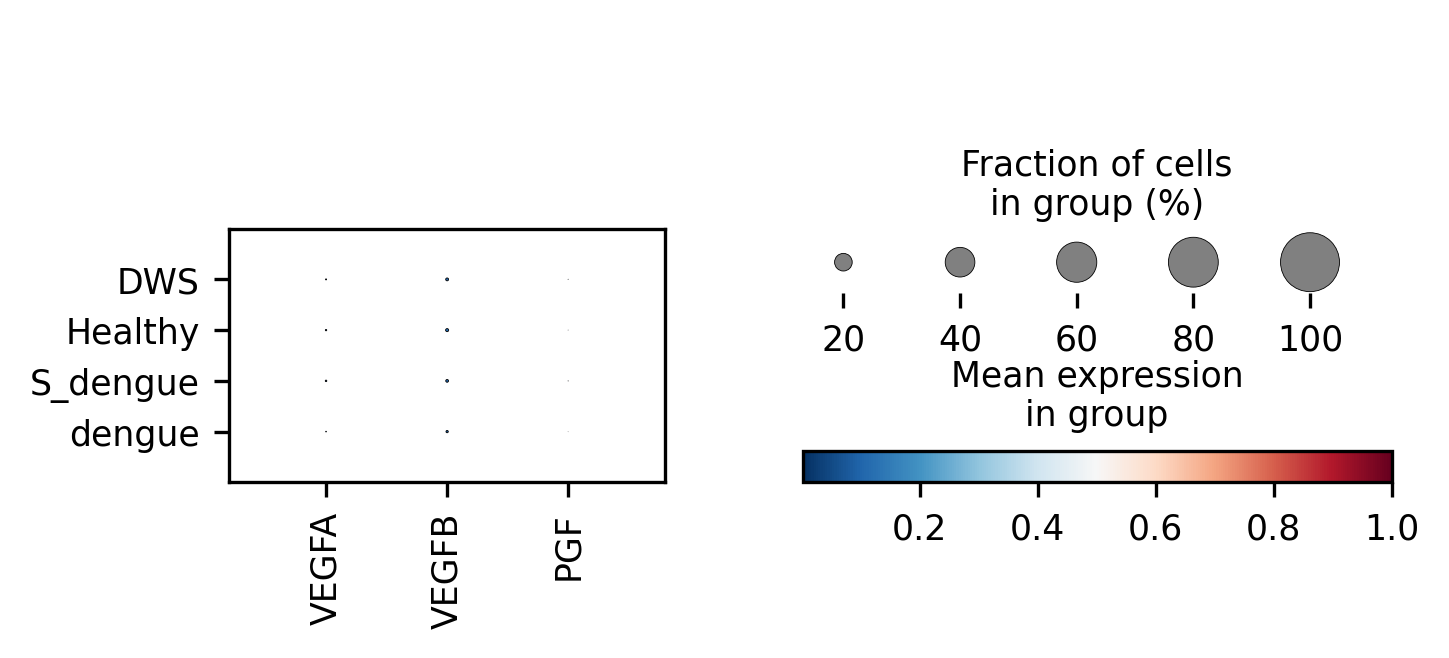

In [42]:
fig,ax = plt.subplots(figsize=(5,2), facecolor='white', dpi=300)
sc.pl.dotplot(adata_children, ['VEGFA', 'VEGFB', 'PGF'], groupby='Condition', cmap='RdBu_r', ax=ax, vmax=0.2, dot_max=1)

/home/yike/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical


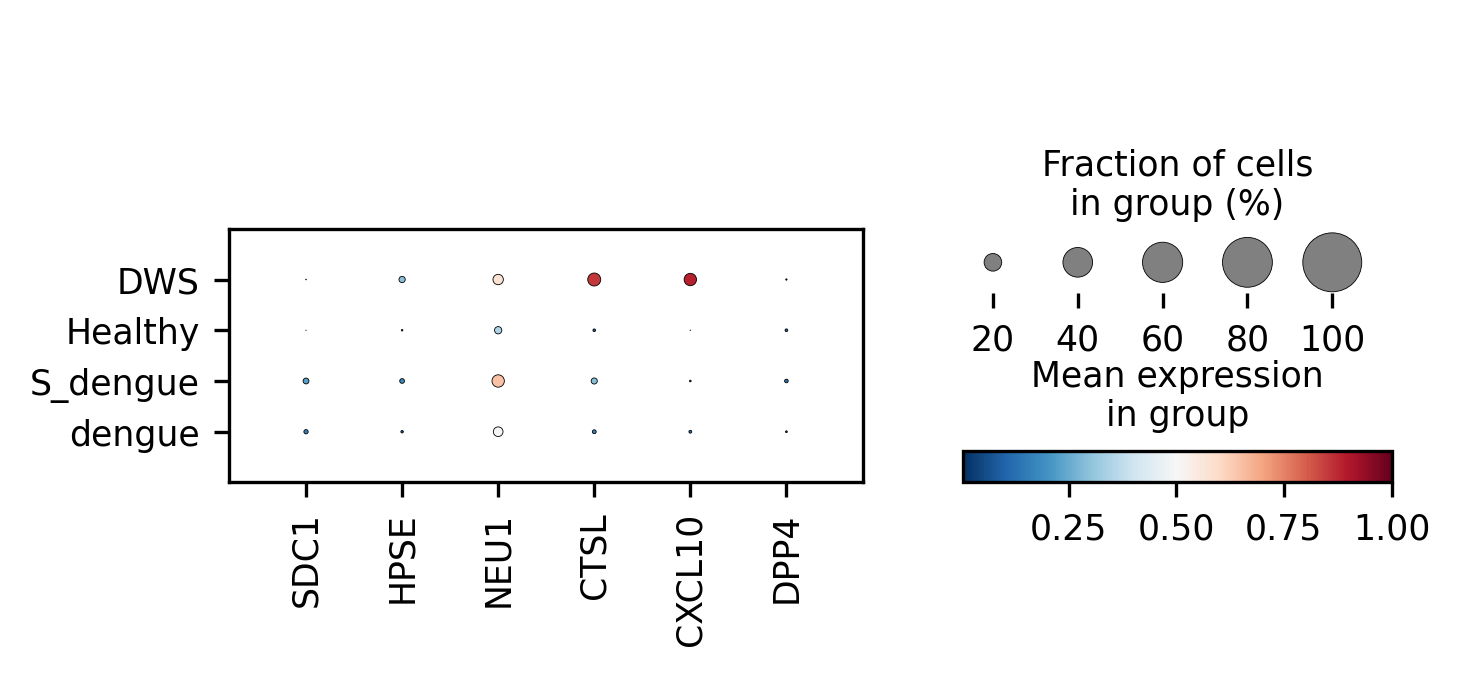

In [4]:
fig,ax = plt.subplots(figsize=(5,2), facecolor='white', dpi=300)
sc.pl.dotplot(adata_children, ['SDC1', 'HPSE', 'NEU1', 'CTSL', 'CXCL10', 'DPP4'], groupby='Condition', cmap='RdBu_r', ax=ax, vmax=1, dot_max=1)

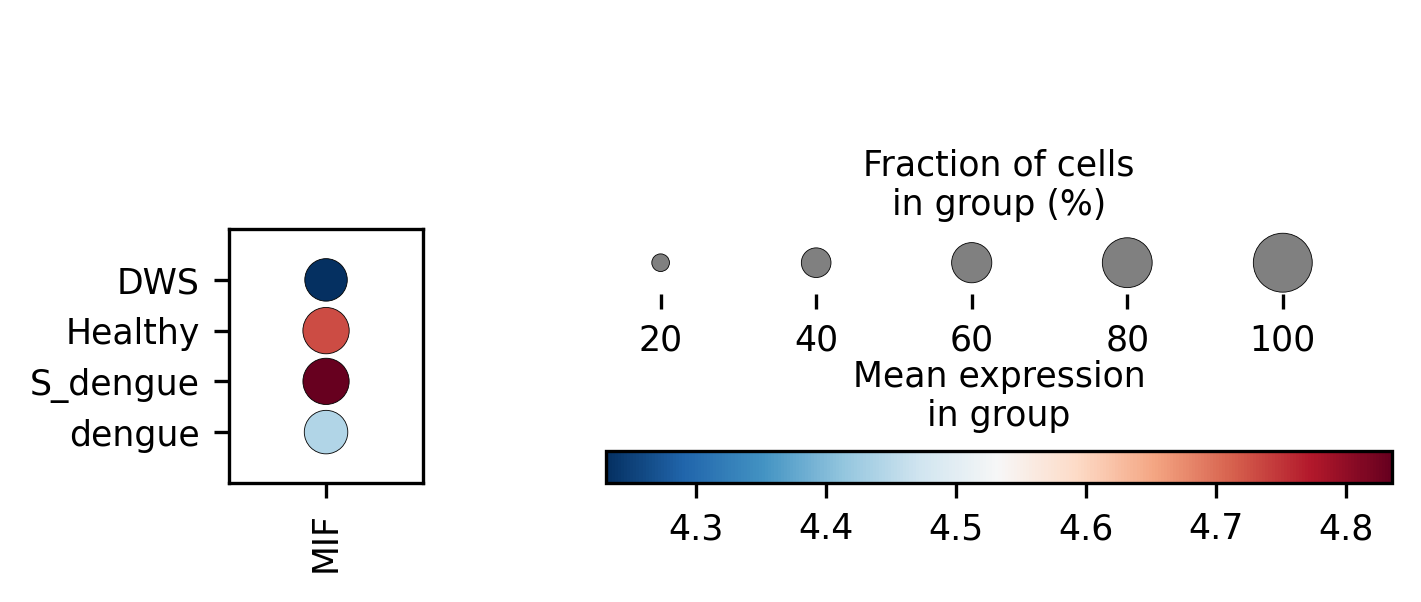

In [14]:
fig,ax = plt.subplots(figsize=(5,2), facecolor='white', dpi=300)
sc.pl.dotplot(adata_children, ['MIF'], groupby='Condition', cmap='RdBu_r', ax=ax, dot_max=1)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
/home/yike/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
/home/yike/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
/home/yike/.local/lib/python3.9/site-pac

{'figure': <Figure size 3000x2400 with 16 Axes>,
 'subplots': array([[<AxesSubplot:title={'left':'S_dengue child'}>,
         <AxesSubplot:title={'left':'dengue child'}>],
        [<AxesSubplot:title={'left':'S_dengue adult'}>,
         <AxesSubplot:title={'left':'dengue adult'}>]], dtype=object)}

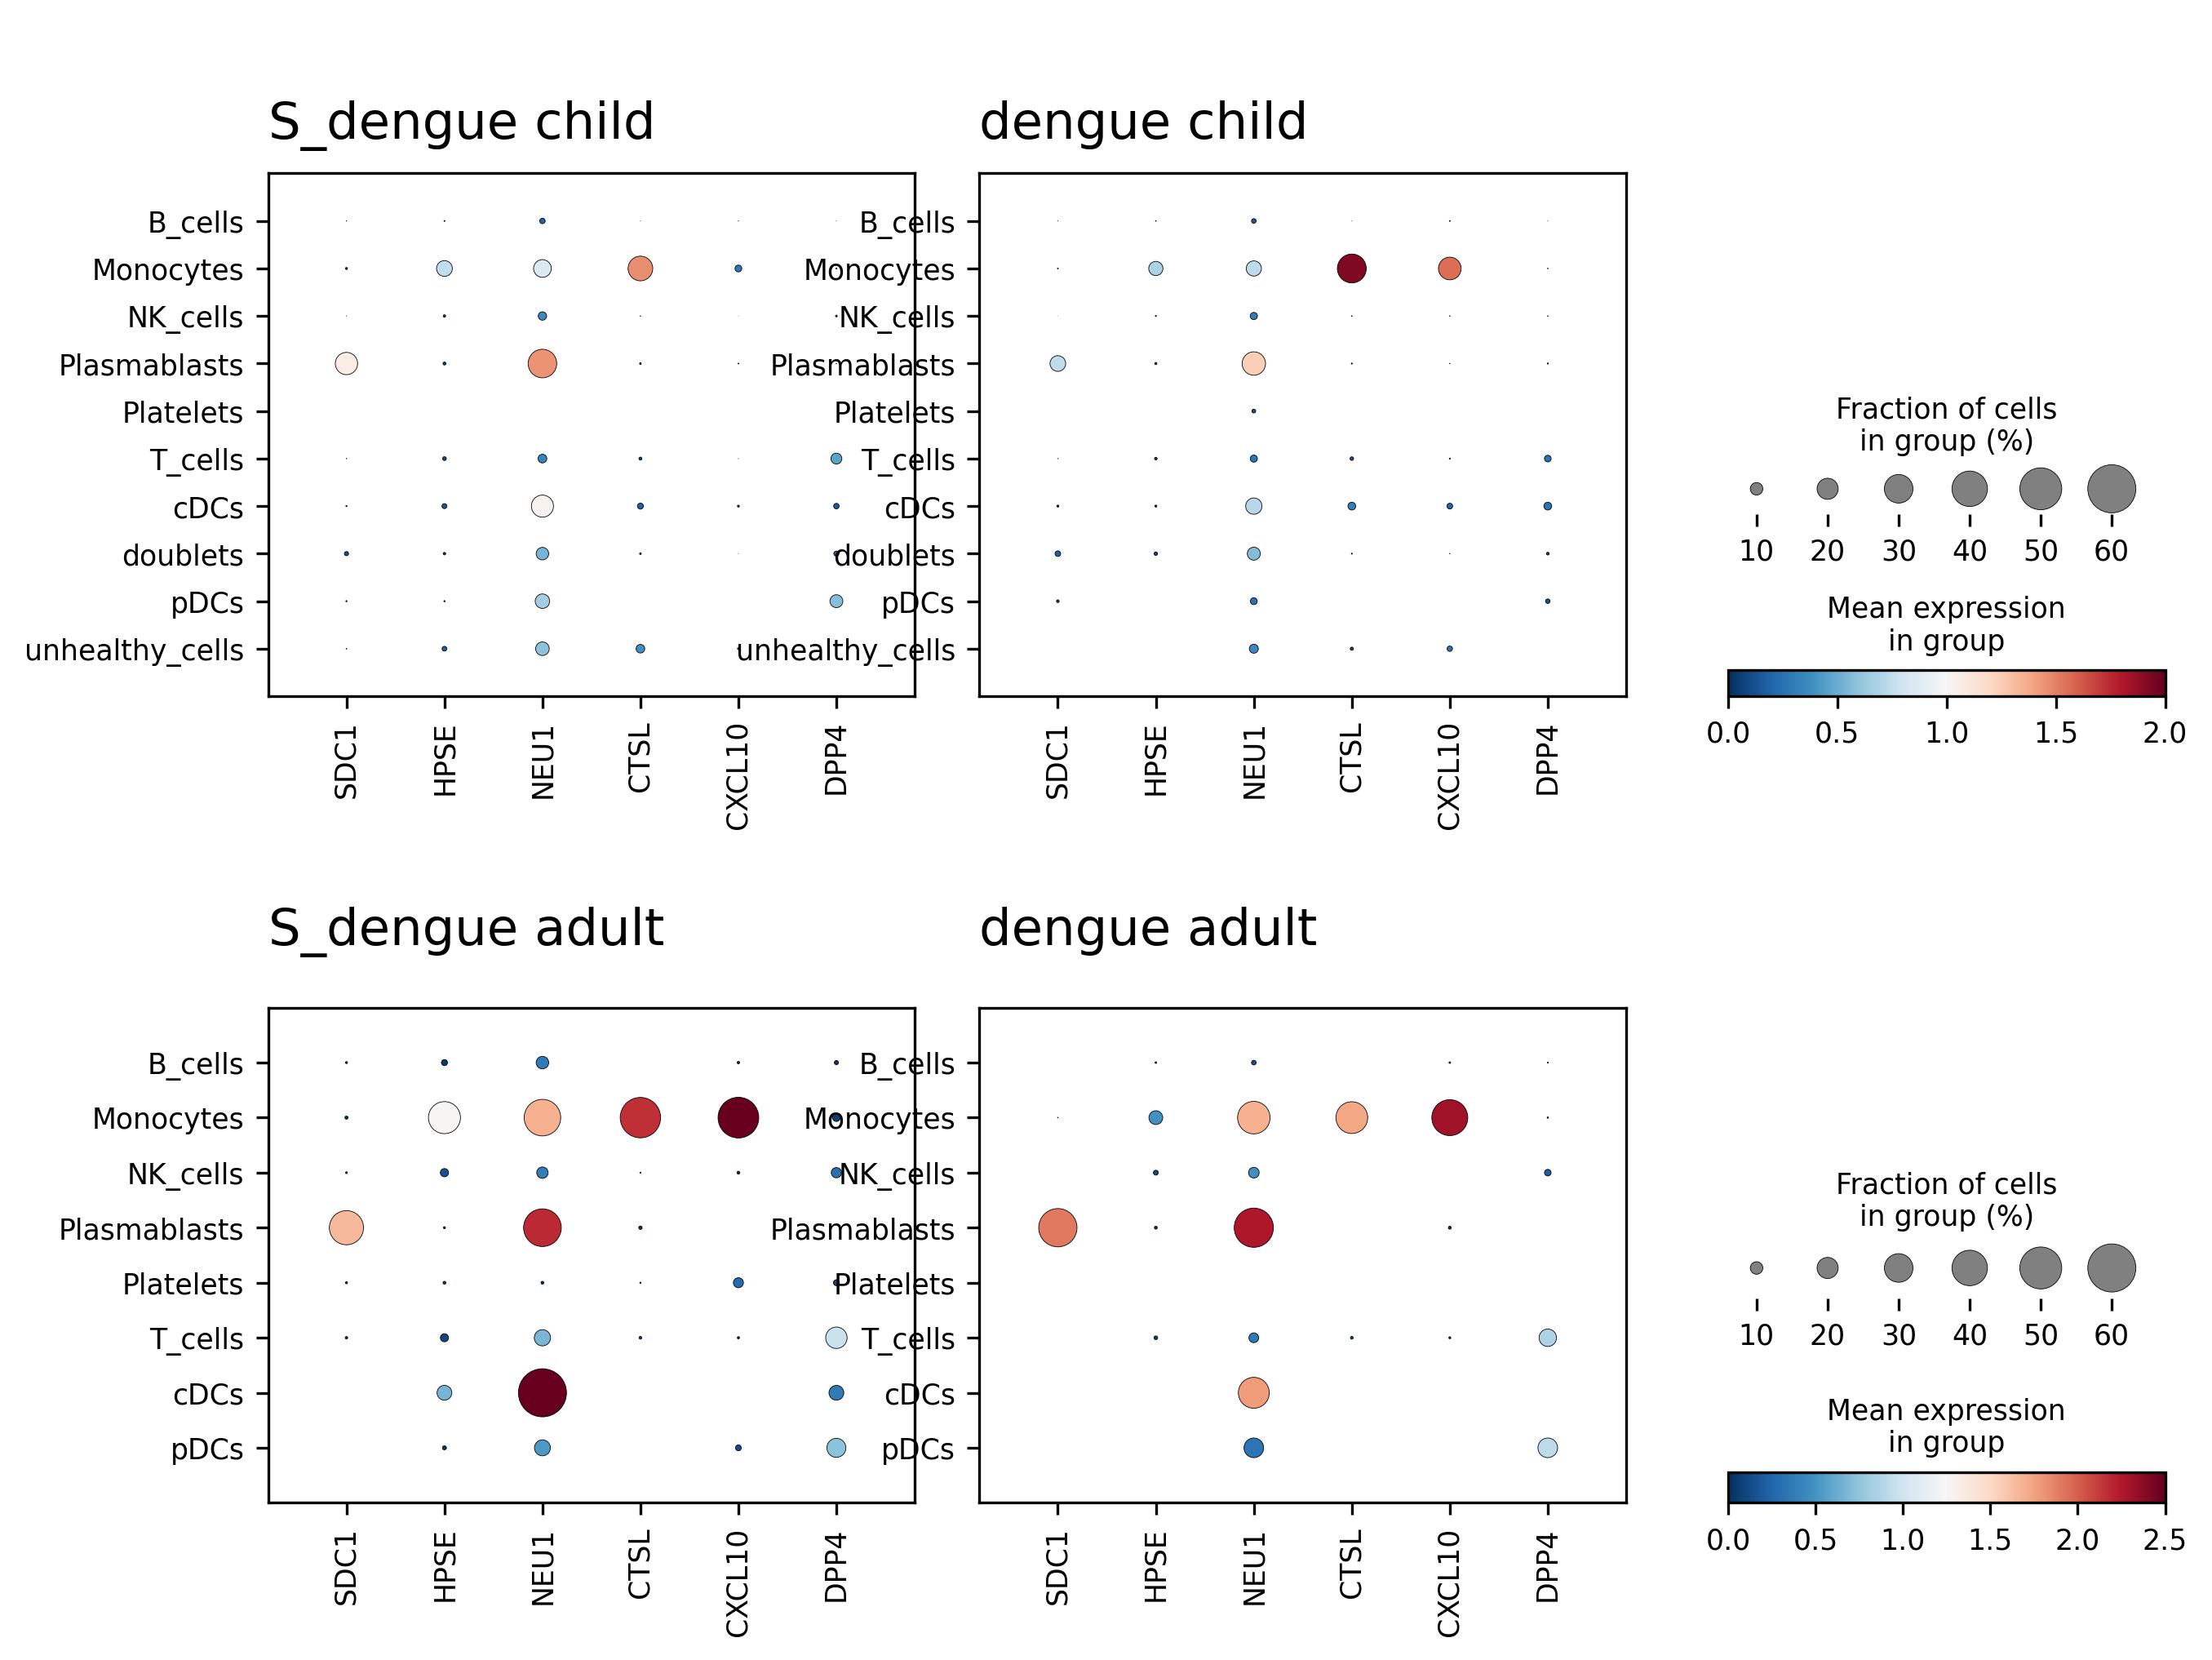

In [6]:
S_dengue_vs_dengue(adata, 'S_dengue', 'dengue', 'cell_type', ['SDC1', 'HPSE', 'NEU1', 'CTSL', 'CXCL10', 'DPP4'], 2)

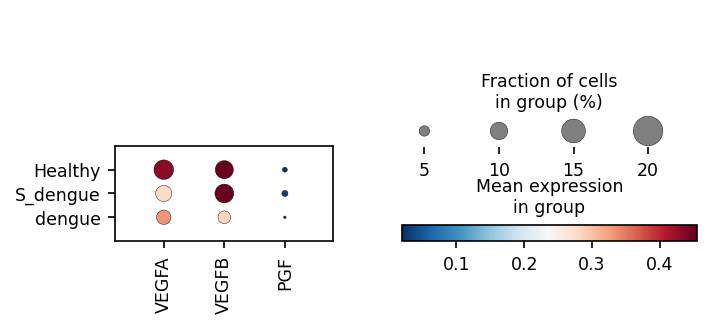

In [34]:
fig,ax = plt.subplots(figsize=(5,2), facecolor='white', dpi=150)
sc.pl.dotplot(adata_adults, ['VEGFA', 'VEGFB', 'PGF'], groupby='Condition', cmap='RdBu_r', ax=ax)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
/home/yike/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
/home/yike/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
/home/yike/.local/lib/python3.9/site-pac

{'figure': <Figure size 3000x2400 with 16 Axes>,
 'subplots': array([[<AxesSubplot:title={'left':'S_dengue child'}>,
         <AxesSubplot:title={'left':'dengue child'}>],
        [<AxesSubplot:title={'left':'S_dengue adult'}>,
         <AxesSubplot:title={'left':'dengue adult'}>]], dtype=object)}

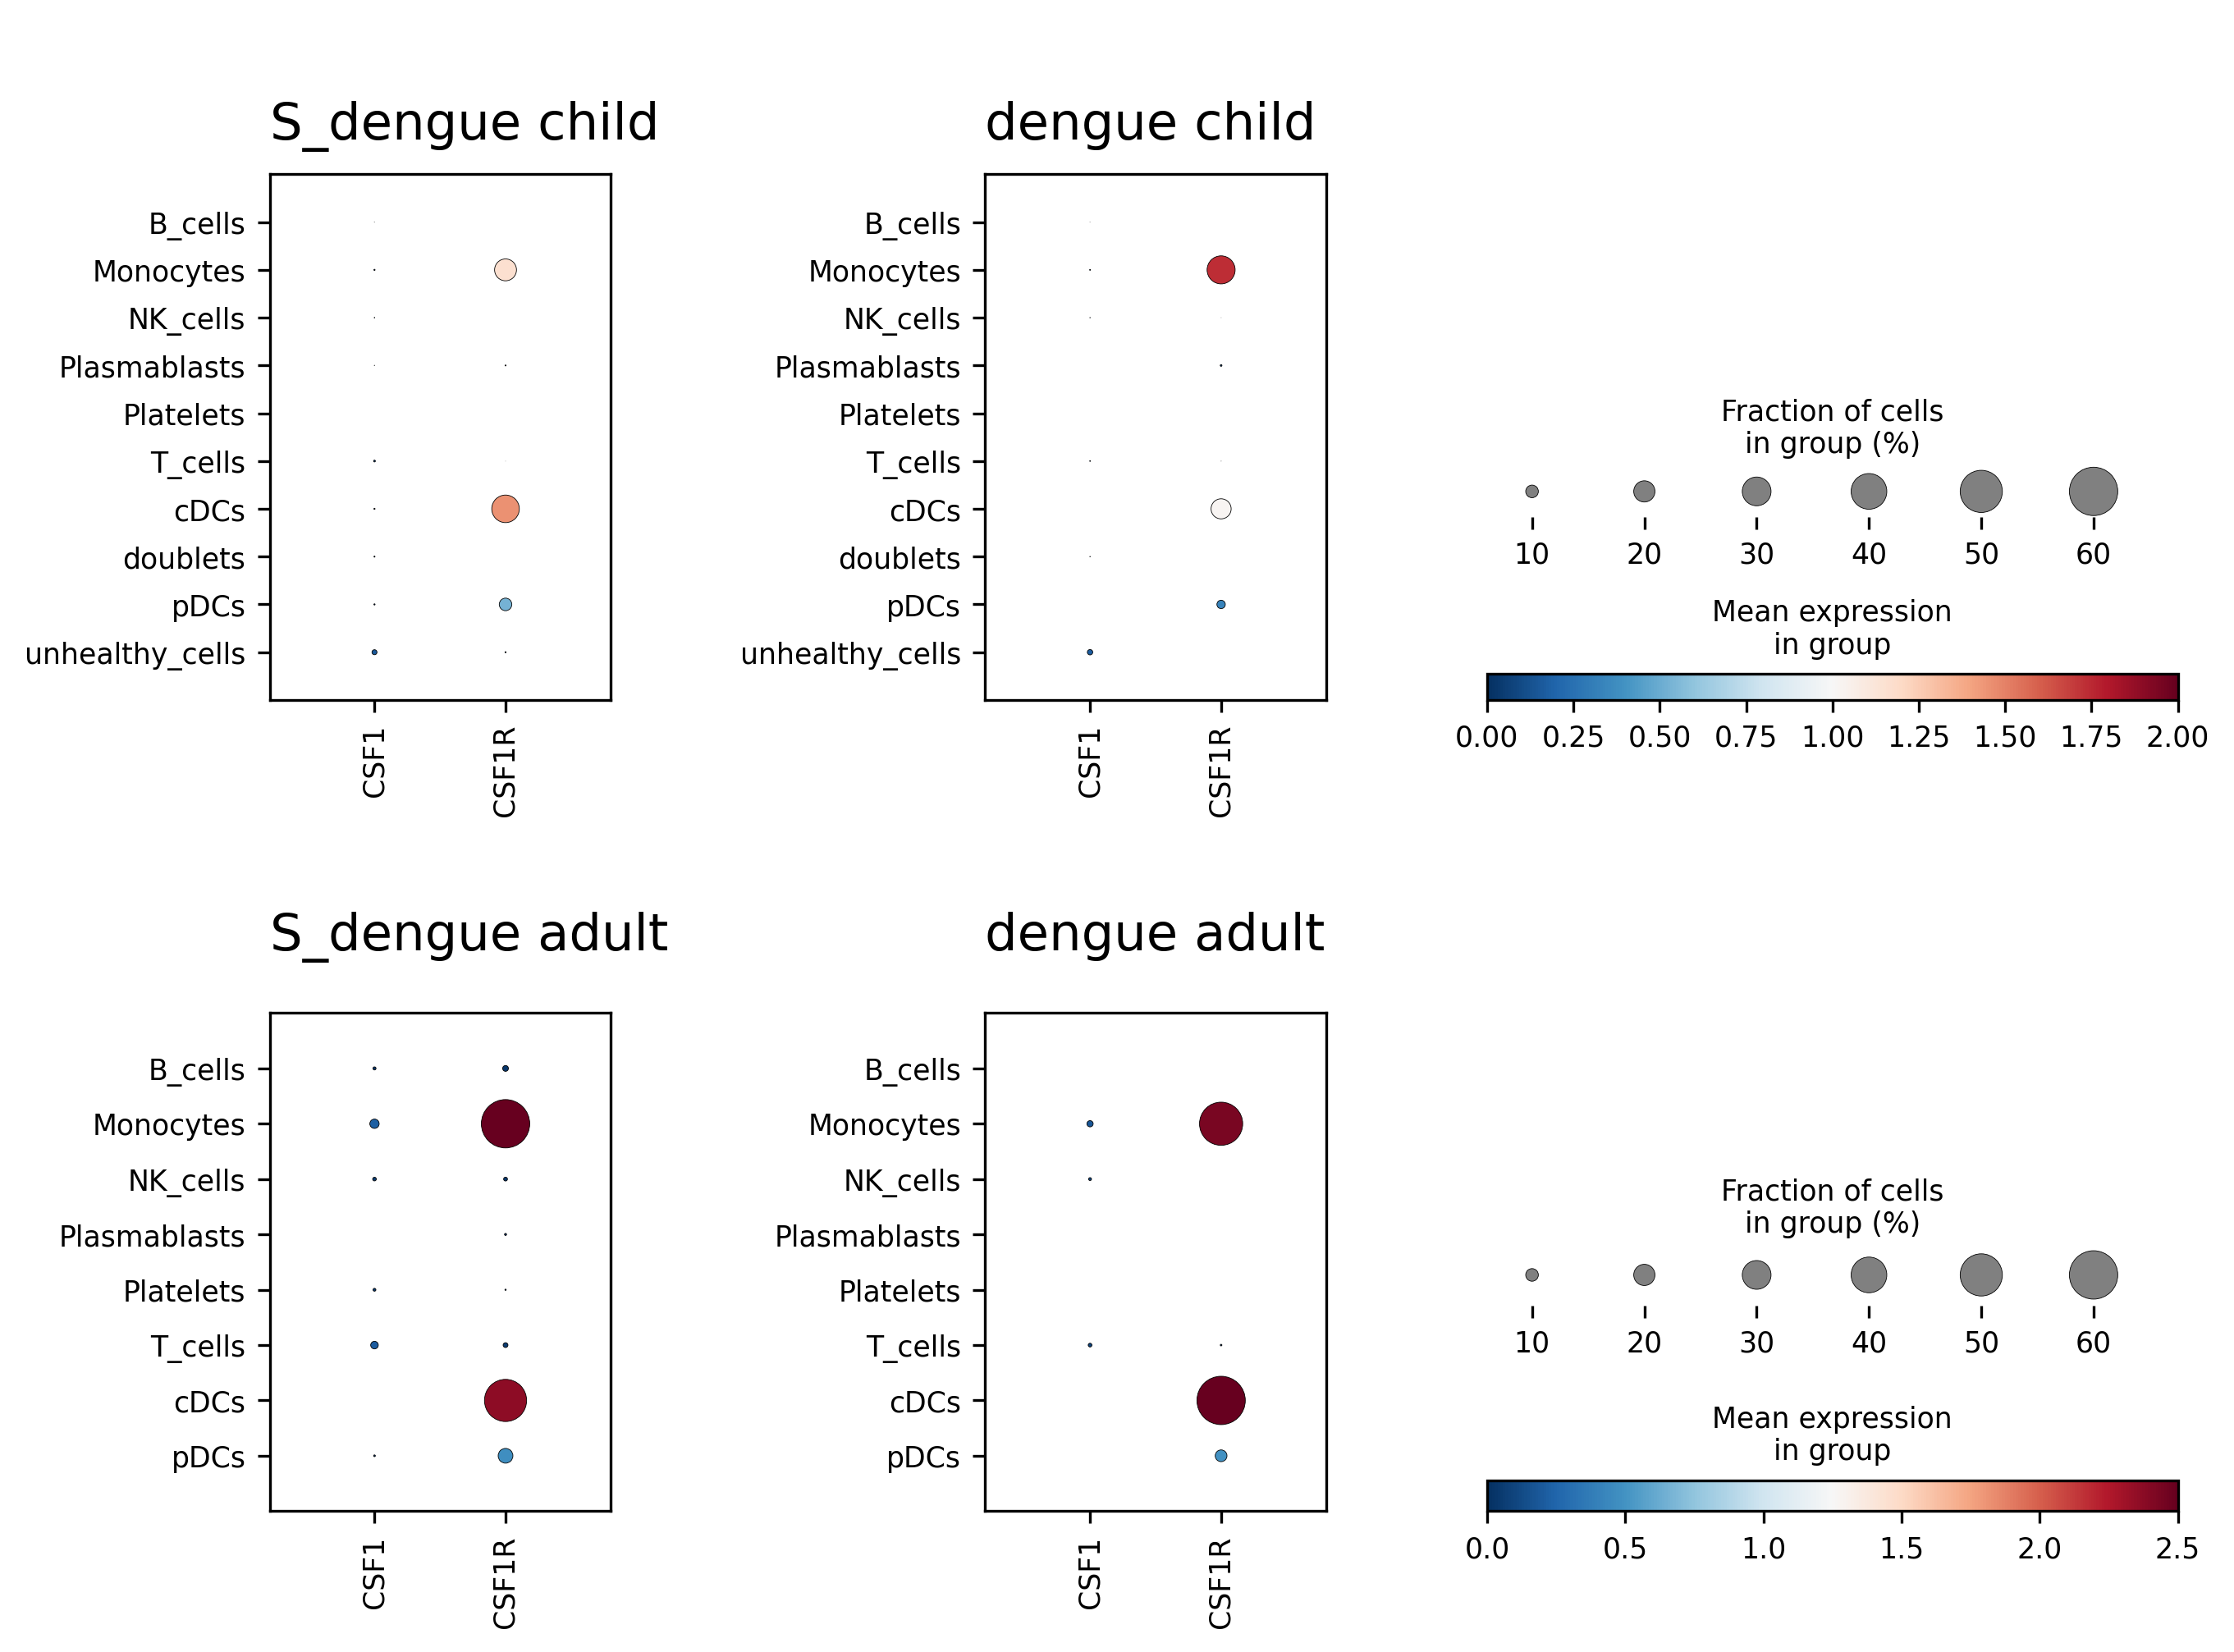

In [40]:
S_dengue_vs_dengue(adata, 'S_dengue', 'dengue', 'cell_type', ['CSF1', 'CSF1R'], 2)

/usr/lib/python3.9/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/yike/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
/home/yike/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
/home/yike/.local/lib/python3.9/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
/home/yike/.local/lib/python3.9/site-pac

{'figure': <Figure size 3000x2400 with 16 Axes>,
 'subplots': array([[<AxesSubplot:title={'left':'S_dengue child'}>,
         <AxesSubplot:title={'left':'dengue child'}>],
        [<AxesSubplot:title={'left':'S_dengue adult'}>,
         <AxesSubplot:title={'left':'dengue adult'}>]], dtype=object)}

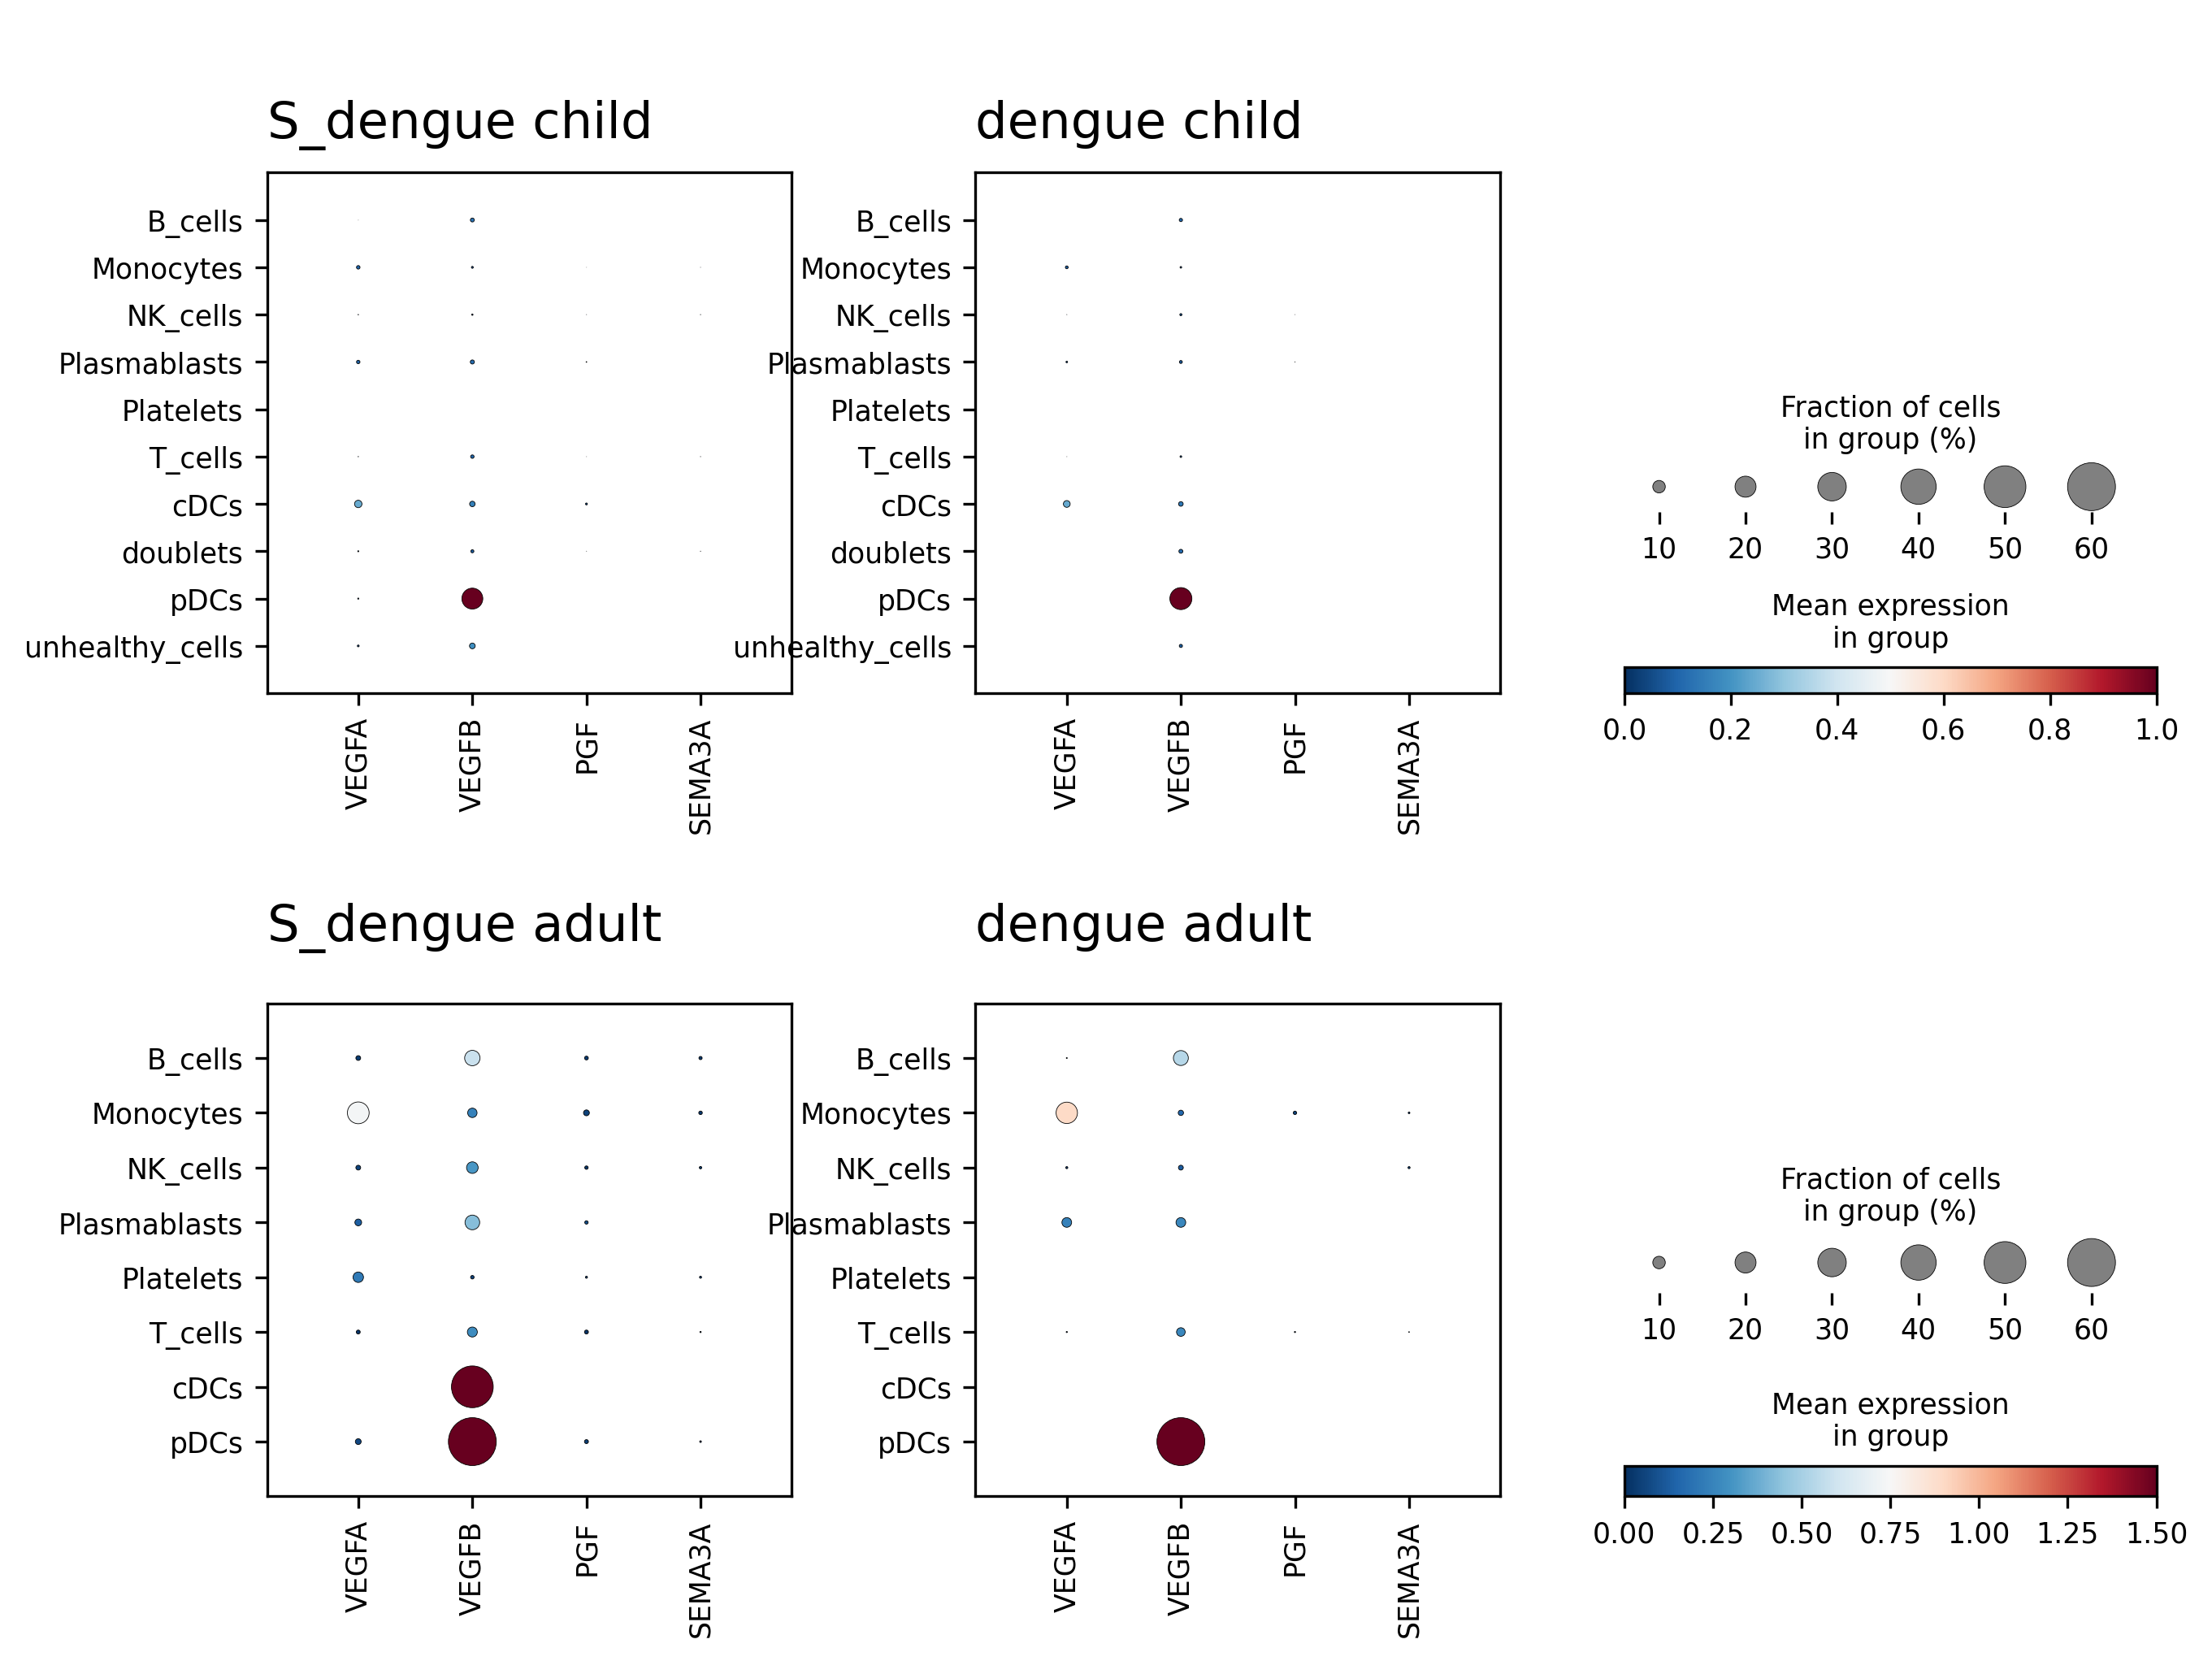

In [24]:
S_dengue_vs_dengue(adata, 'S_dengue', 'dengue', 'cell_type', ['VEGFA', 'VEGFB', 'PGF', 'SEMA3A'])

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/

{'figure': <Figure size 3000x2400 with 16 Axes>,
 'subplots': array([[<AxesSubplot:title={'left':'S_dengue child'}>,
         <AxesSubplot:title={'left':'dengue child'}>],
        [<AxesSubplot:title={'left':'S_dengue adult'}>,
         <AxesSubplot:title={'left':'dengue adult'}>]], dtype=object)}

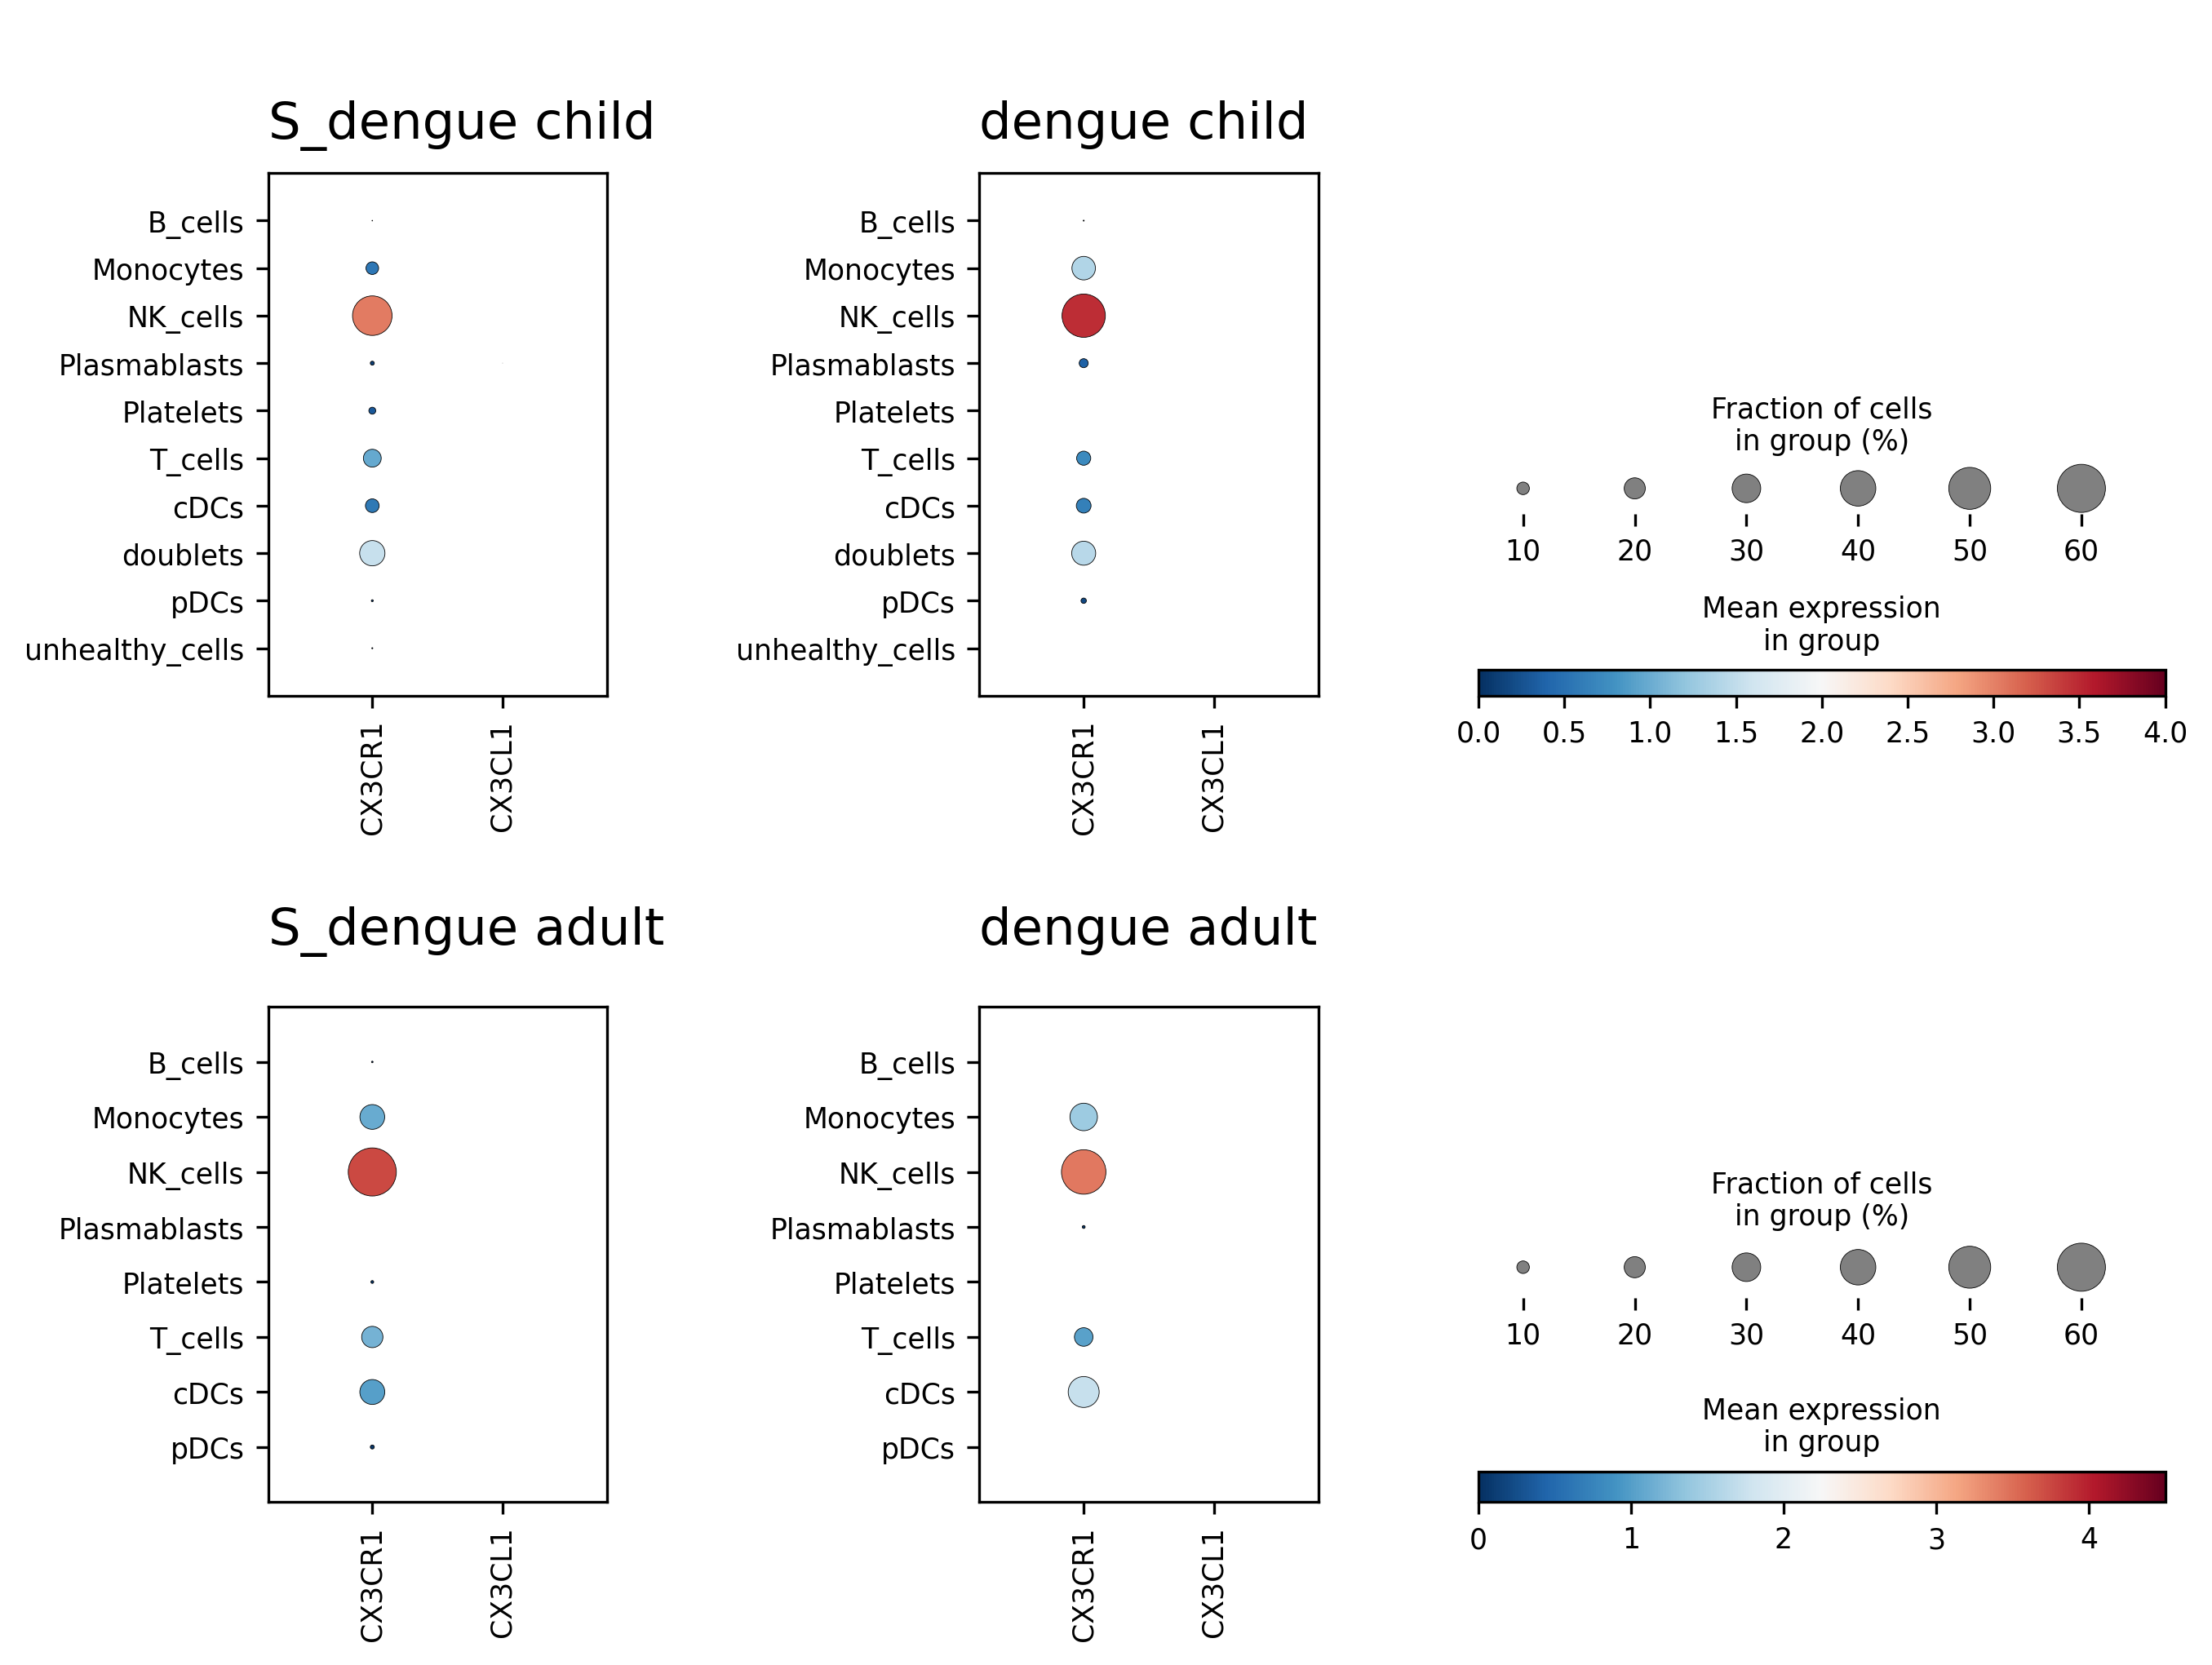

In [29]:
S_dengue_vs_dengue(adata, 'S_dengue', 'dengue', 'cell_type', ['CX3CR1', 'CX3CL1'])

In [20]:
from collections import defaultdict

cell_types = list(adata.obs['cell_type'].astype('category').cat.categories)
adata_ct = {}

for cell_type in cell_types:
    adata_ct[cell_type] = adata[adata.obs['cell_type'] == cell_type]
adata_ct['NK/T'] = adata[adata.obs['cell_type'].isin(['NK_cells', 'T_cells'])]

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/

{'figure': <Figure size 3000x2400 with 16 Axes>,
 'subplots': array([[<AxesSubplot:title={'left':'S_dengue child'}>,
         <AxesSubplot:title={'left':'dengue child'}>],
        [<AxesSubplot:title={'left':'S_dengue adult'}>,
         <AxesSubplot:title={'left':'dengue adult'}>]], dtype=object)}

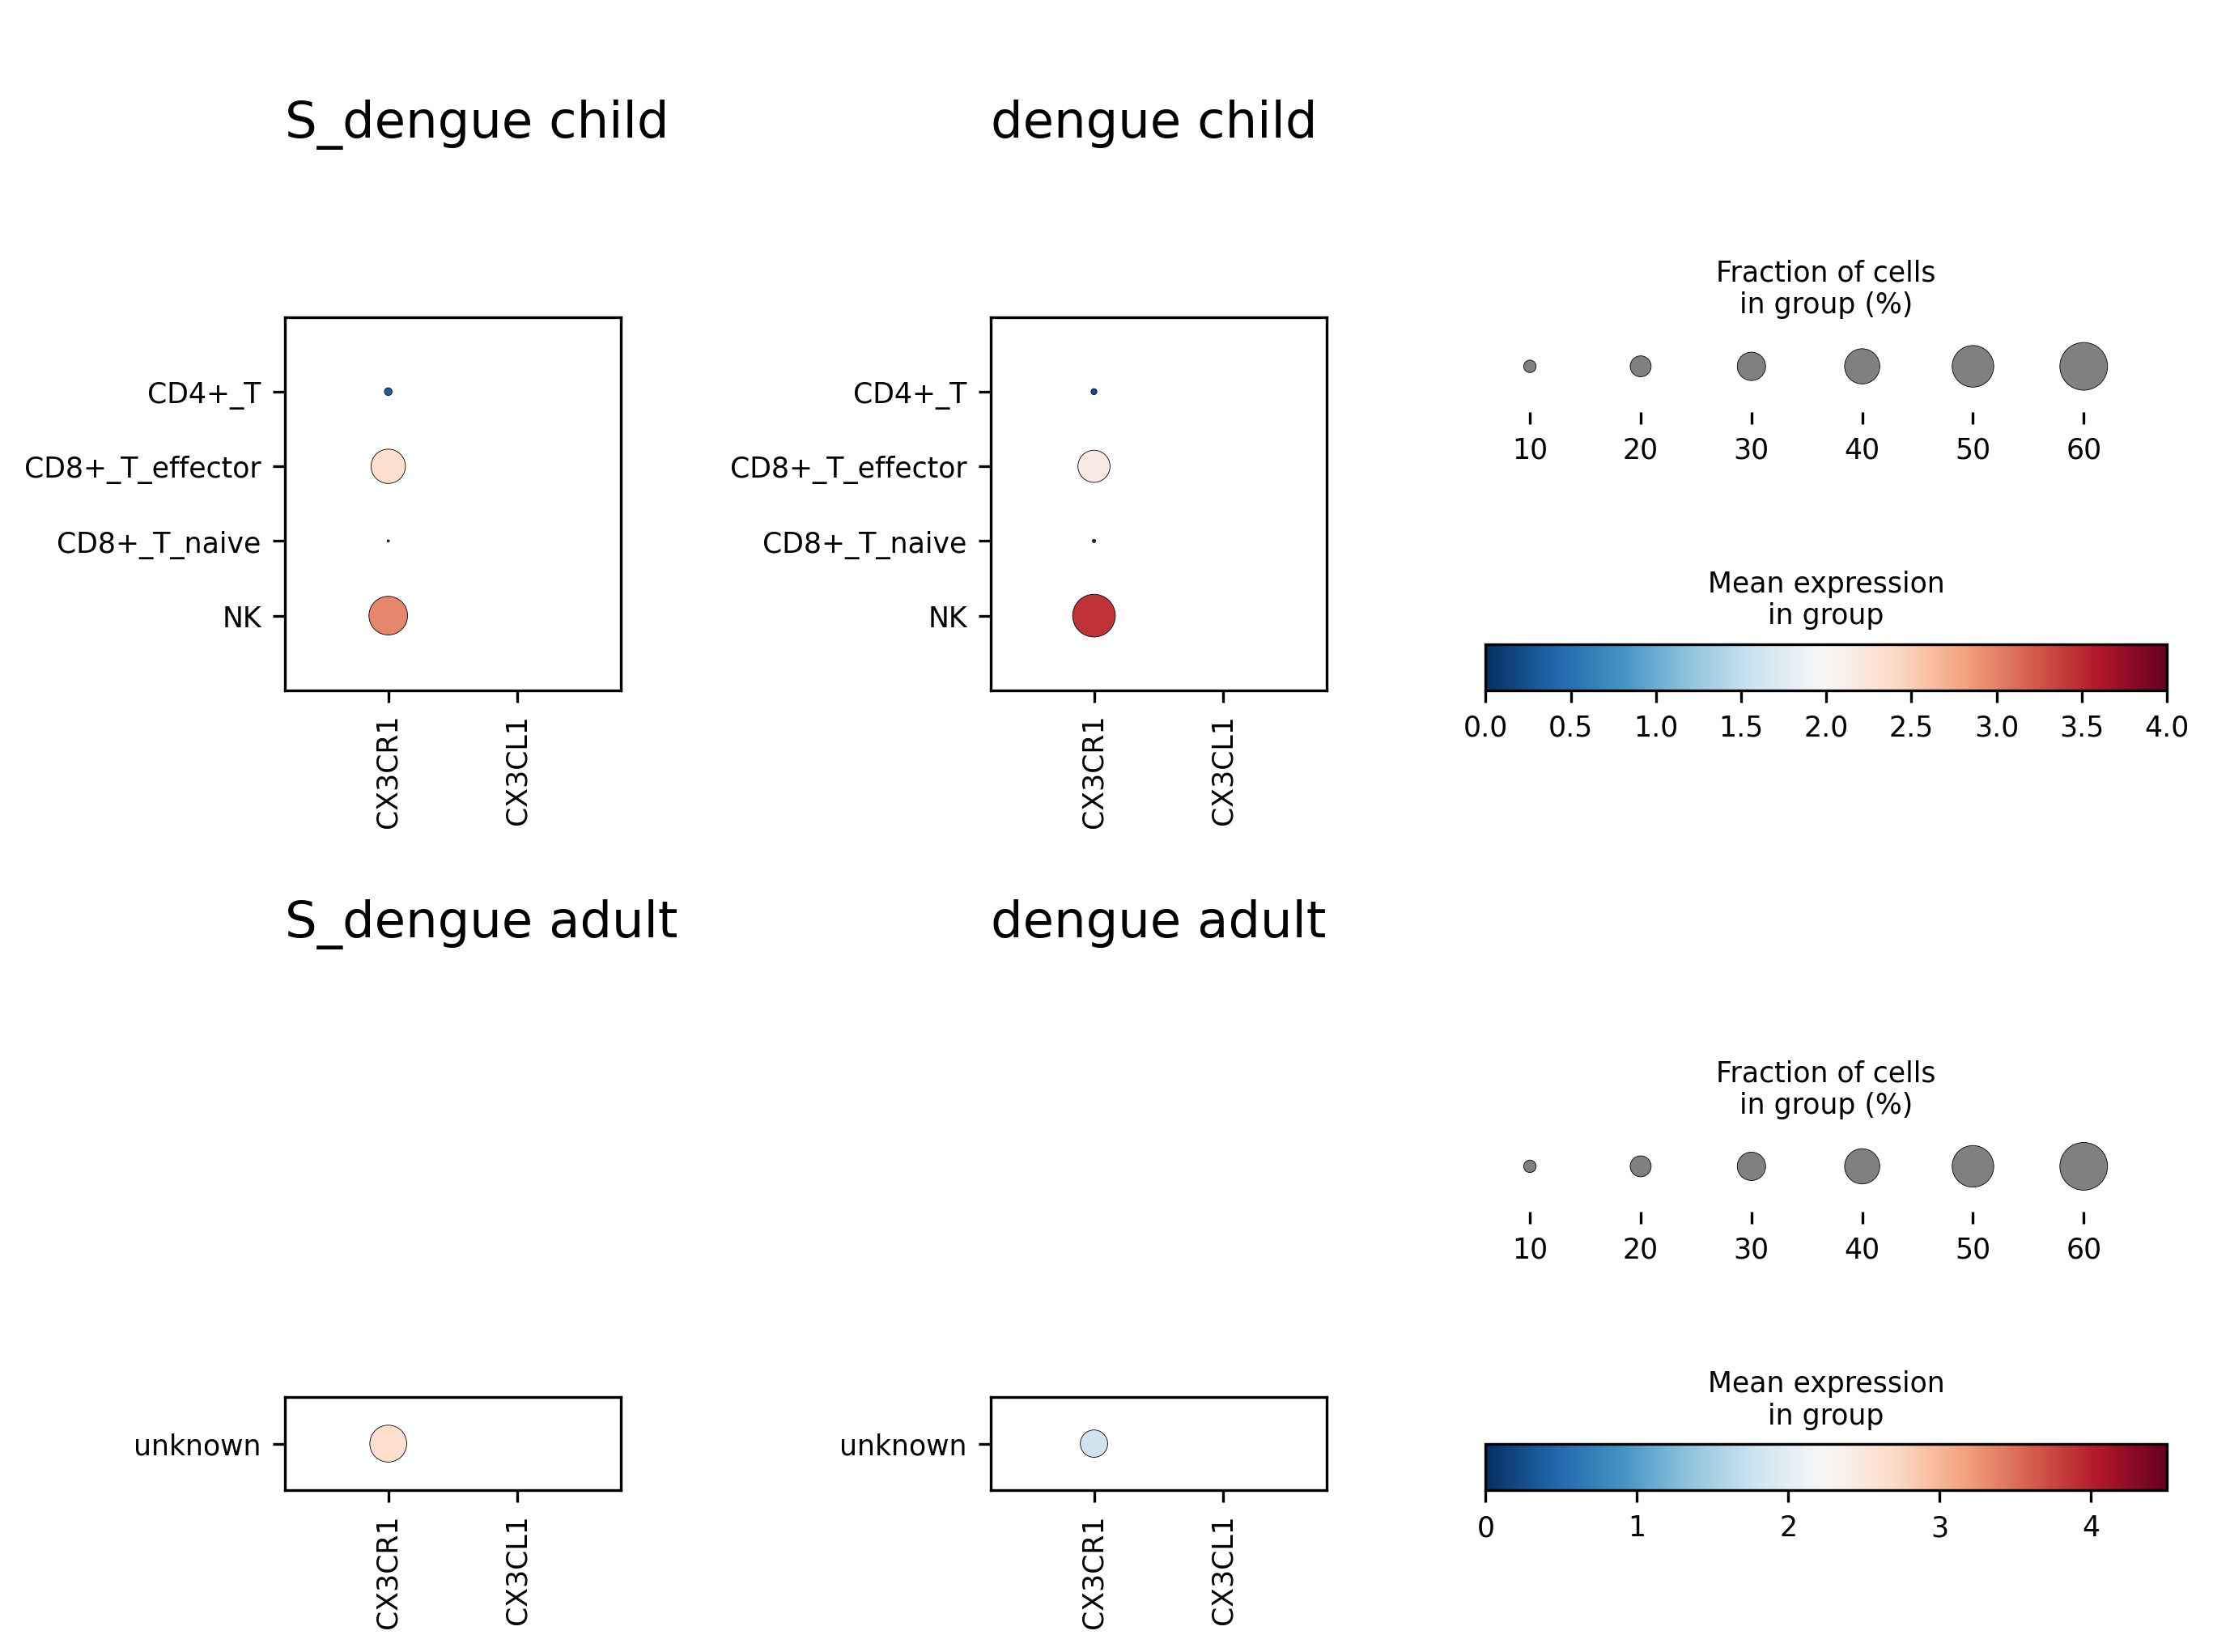

In [31]:
S_dengue_vs_dengue(adata_ct['NK/T'], 'S_dengue', 'dengue', 'cell_subtype', ['CX3CR1', 'CX3CL1'])

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/

{'figure': <Figure size 3000x2400 with 16 Axes>,
 'subplots': array([[<AxesSubplot:title={'left':'S_dengue child'}>,
         <AxesSubplot:title={'left':'dengue child'}>],
        [<AxesSubplot:title={'left':'S_dengue adult'}>,
         <AxesSubplot:title={'left':'dengue adult'}>]], dtype=object)}

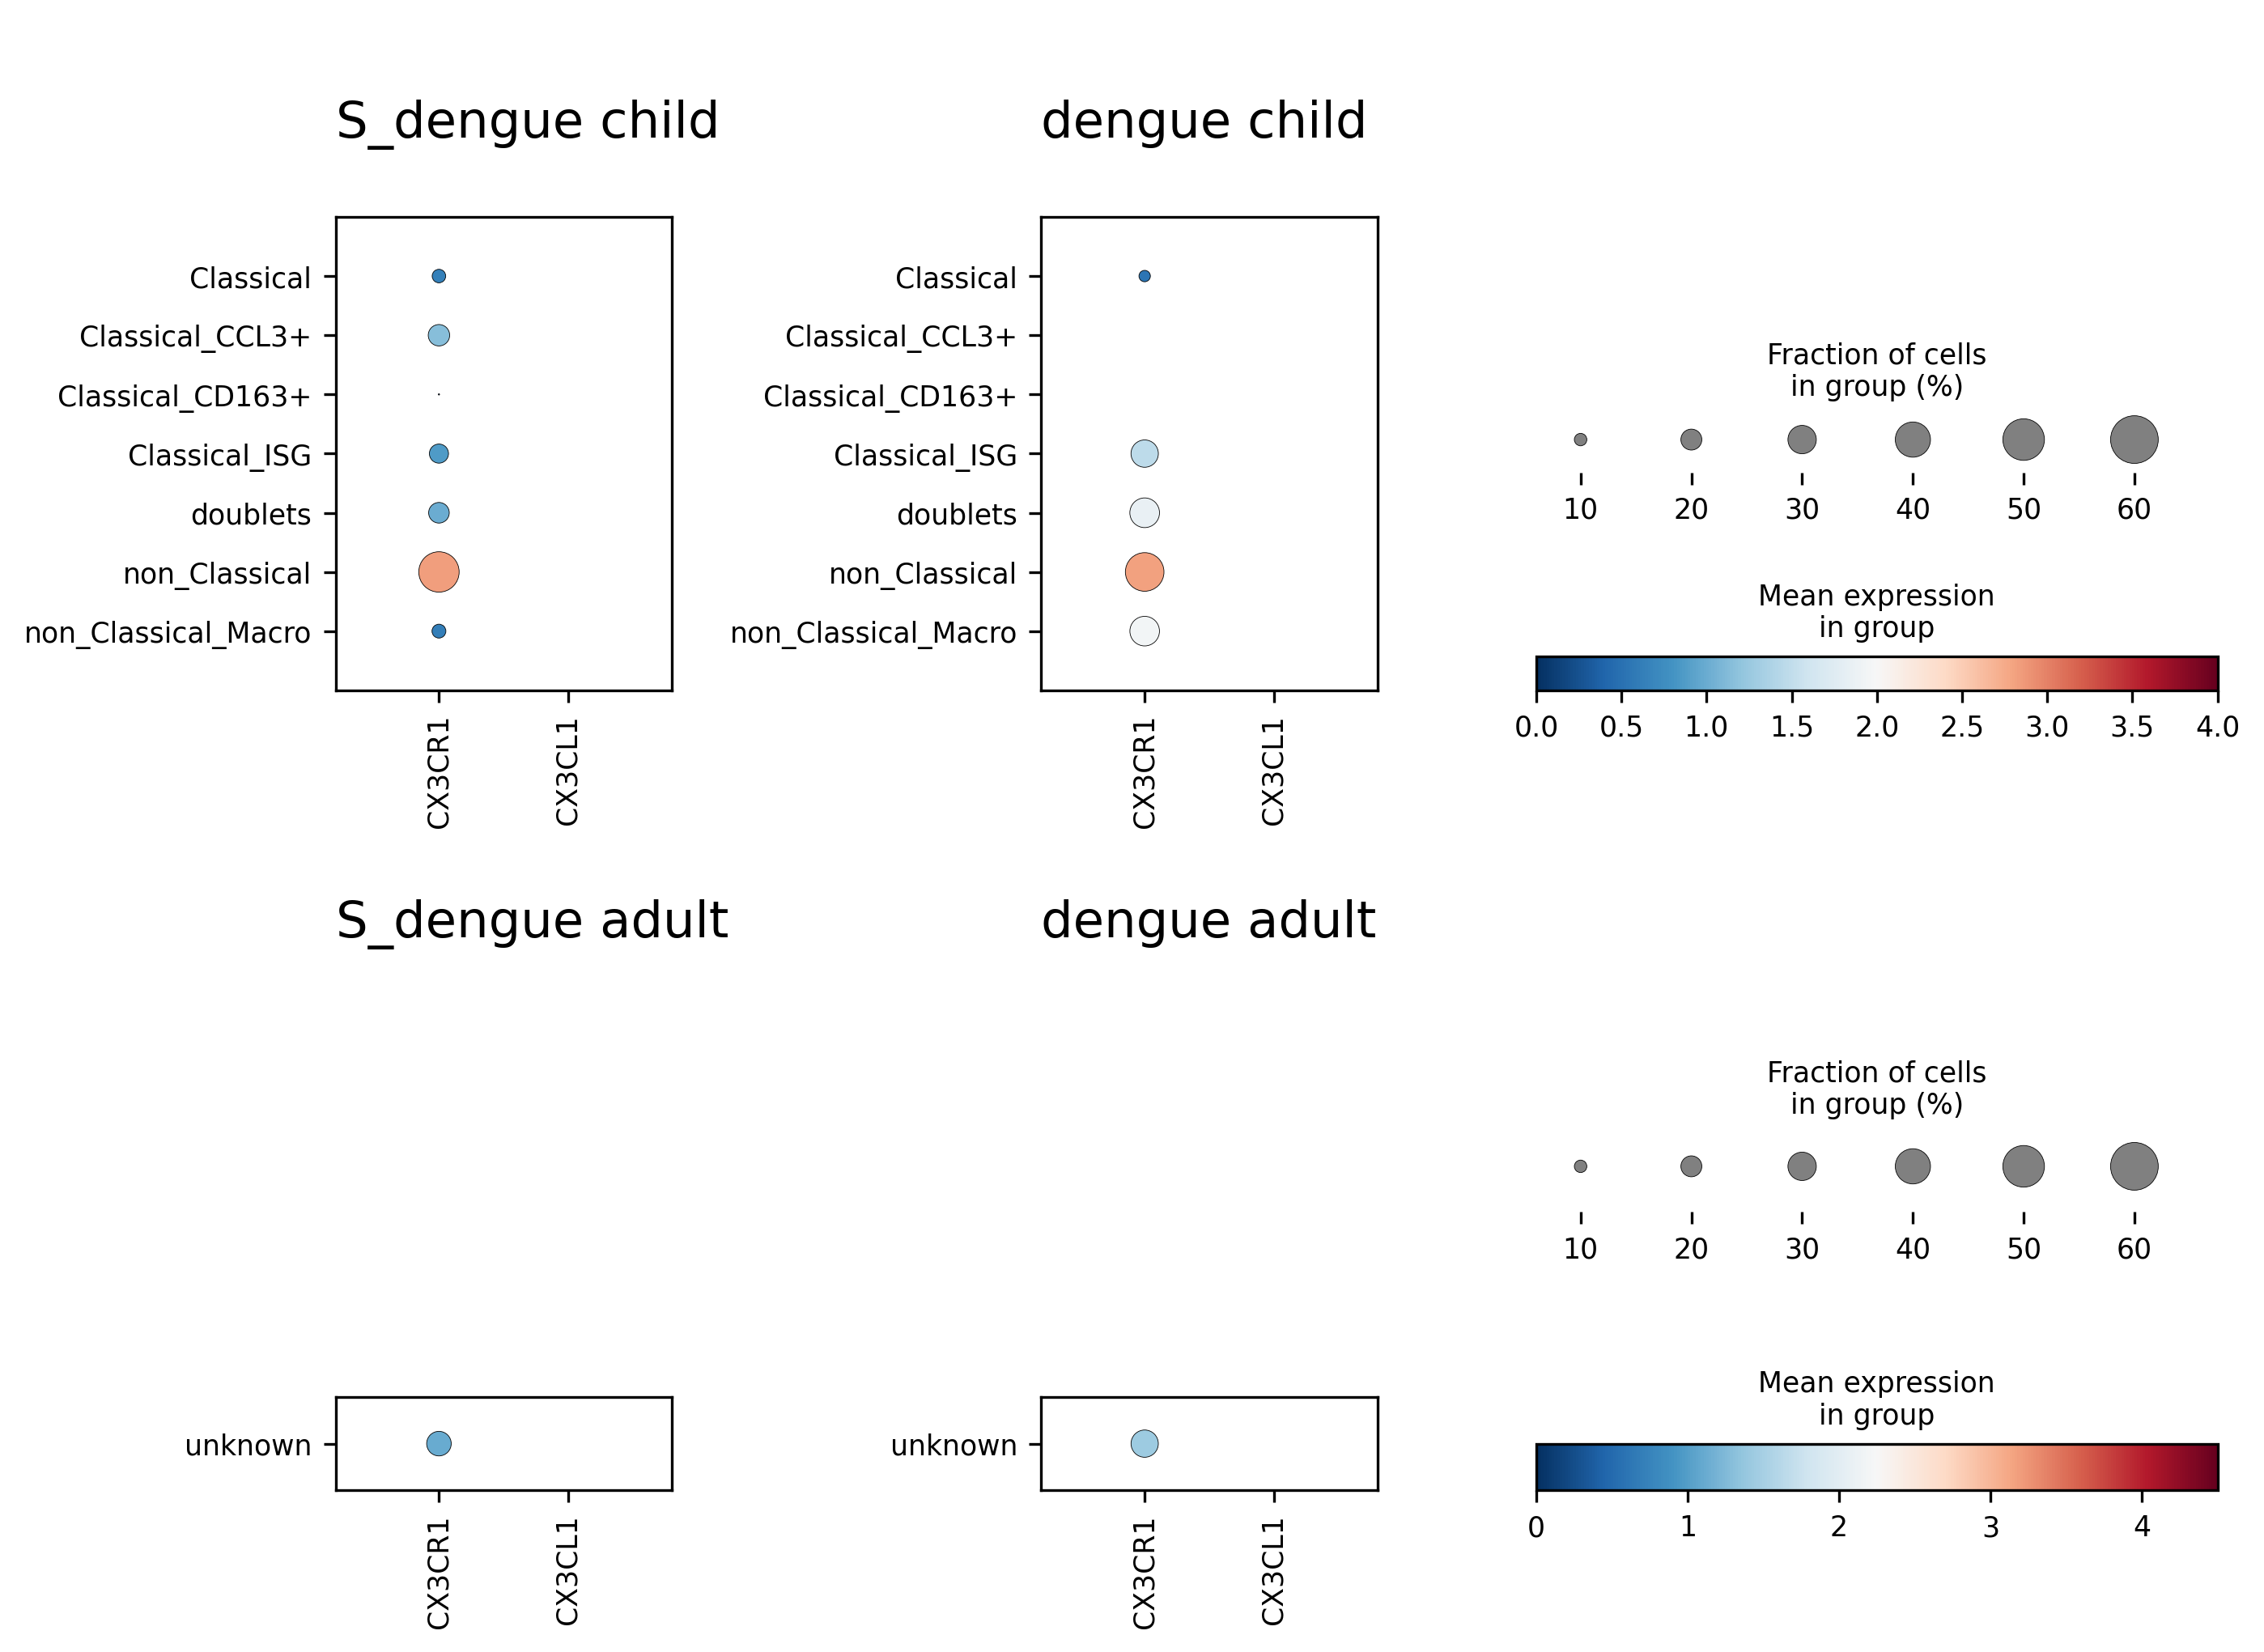

In [30]:
S_dengue_vs_dengue(adata_ct['Monocytes'], 'S_dengue', 'dengue', 'cell_subtype', ['CX3CR1', 'CX3CL1'])

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/

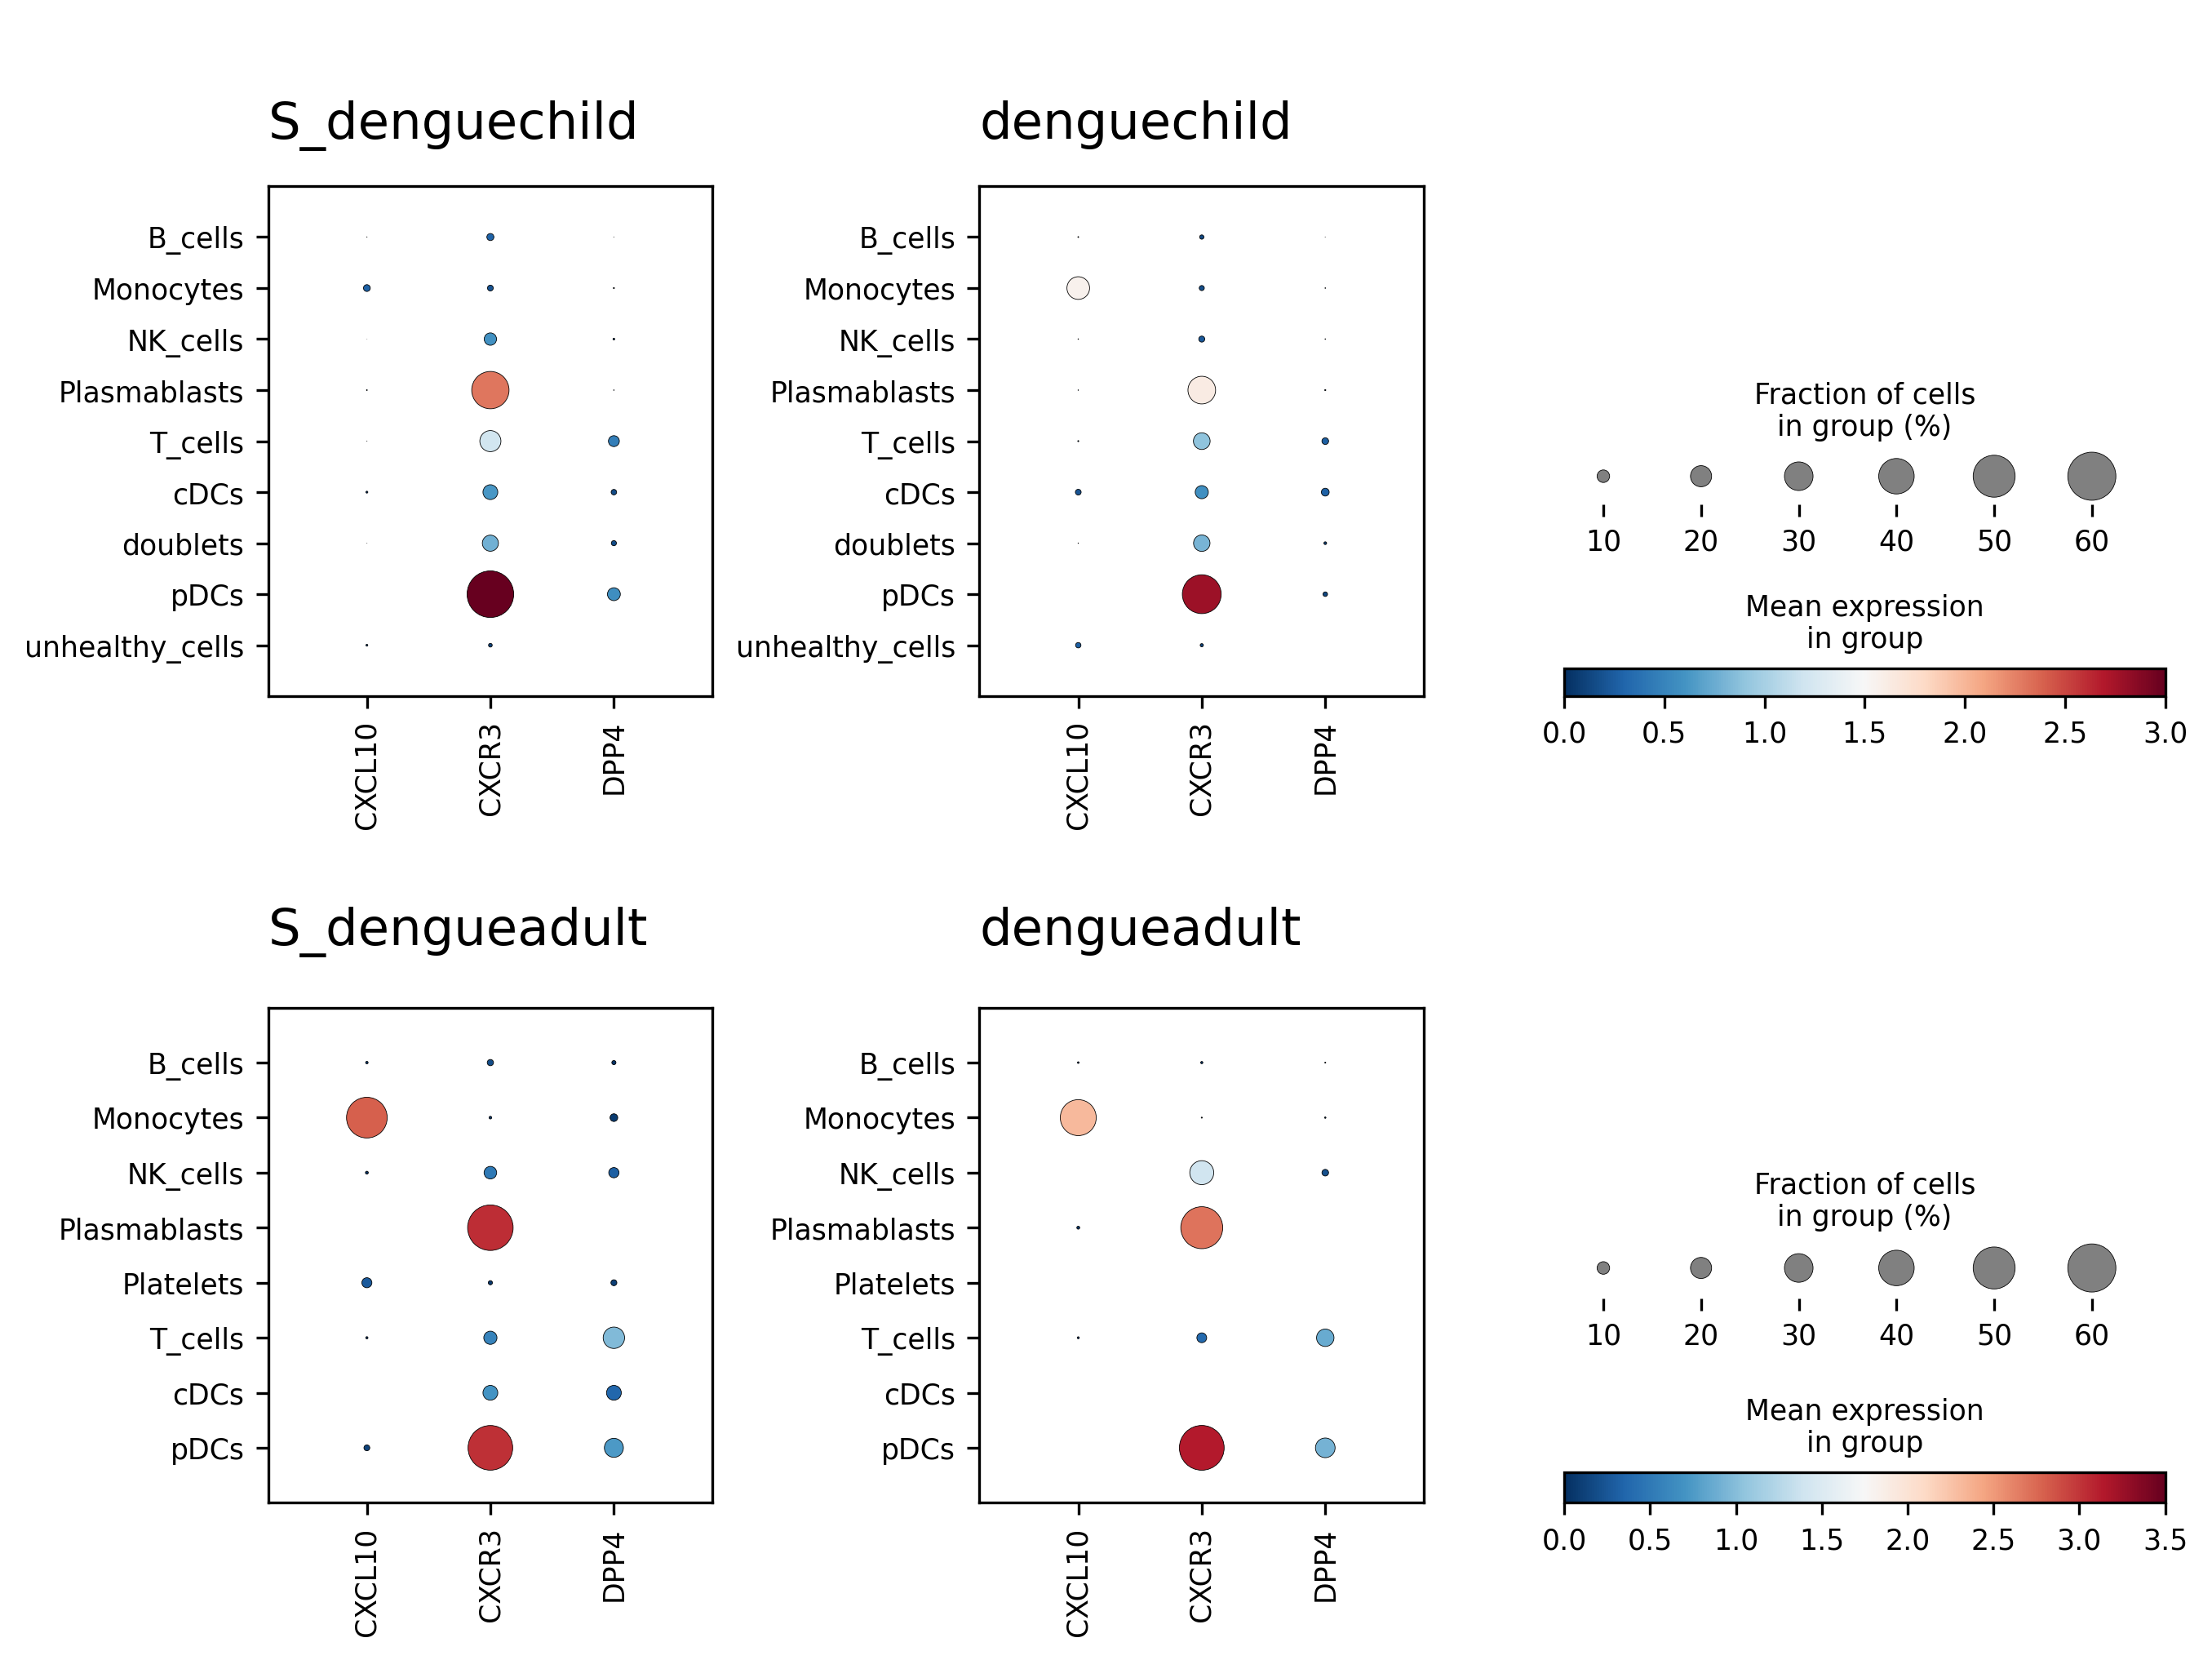

In [64]:
inters = [ 'CXCL10', 'CXCR3', 'DPP4']
ab = S_dengue_vs_dengue(adata, 'S_dengue', 'dengue', 'cell_type', inters)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/

{'figure': <Figure size 3000x2400 with 16 Axes>,
 'subplots': array([[<AxesSubplot:title={'left':'S_denguechild'}>,
         <AxesSubplot:title={'left':'denguechild'}>],
        [<AxesSubplot:title={'left':'S_dengueadult'}>,
         <AxesSubplot:title={'left':'dengueadult'}>]], dtype=object)}

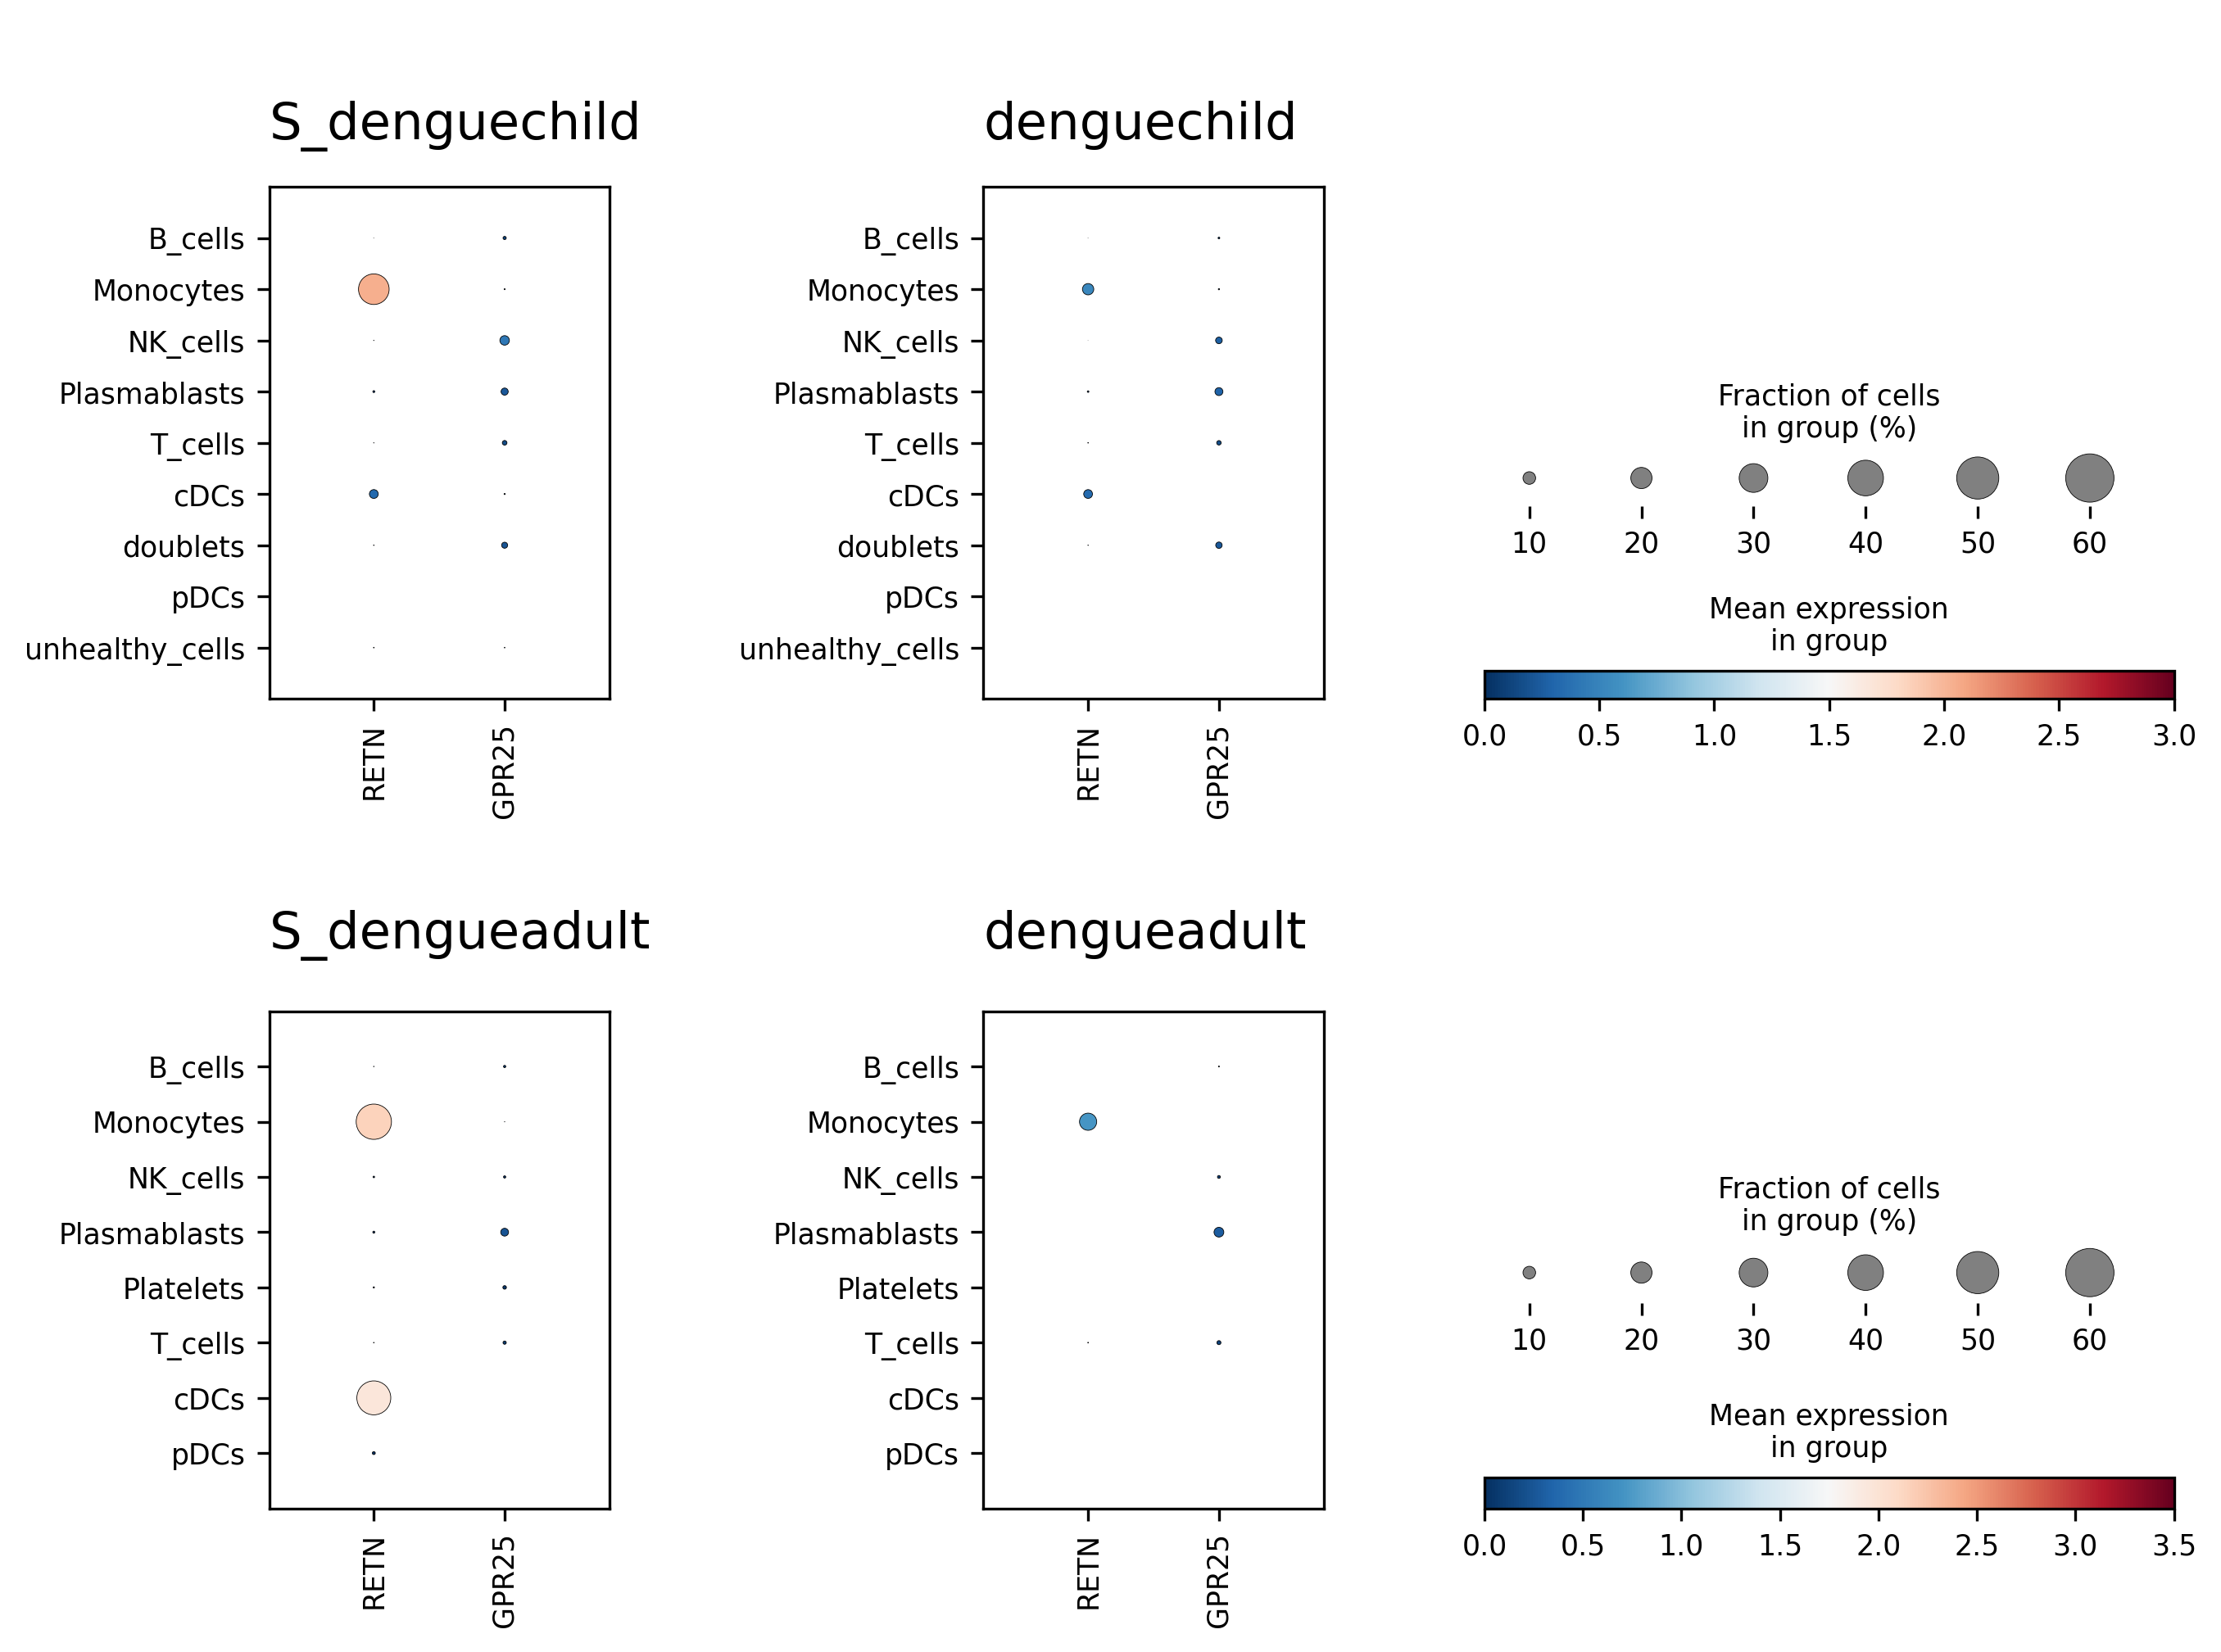

In [48]:
inters = [ 'RETN', 'GPR25']
S_dengue_vs_dengue(adata, 'S_dengue', 'dengue', 'cell_type', inters)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/

{'figure': <Figure size 3000x2400 with 16 Axes>,
 'subplots': array([[<AxesSubplot:title={'left':'S_denguechild'}>,
         <AxesSubplot:title={'left':'denguechild'}>],
        [<AxesSubplot:title={'left':'S_dengueadult'}>,
         <AxesSubplot:title={'left':'dengueadult'}>]], dtype=object)}

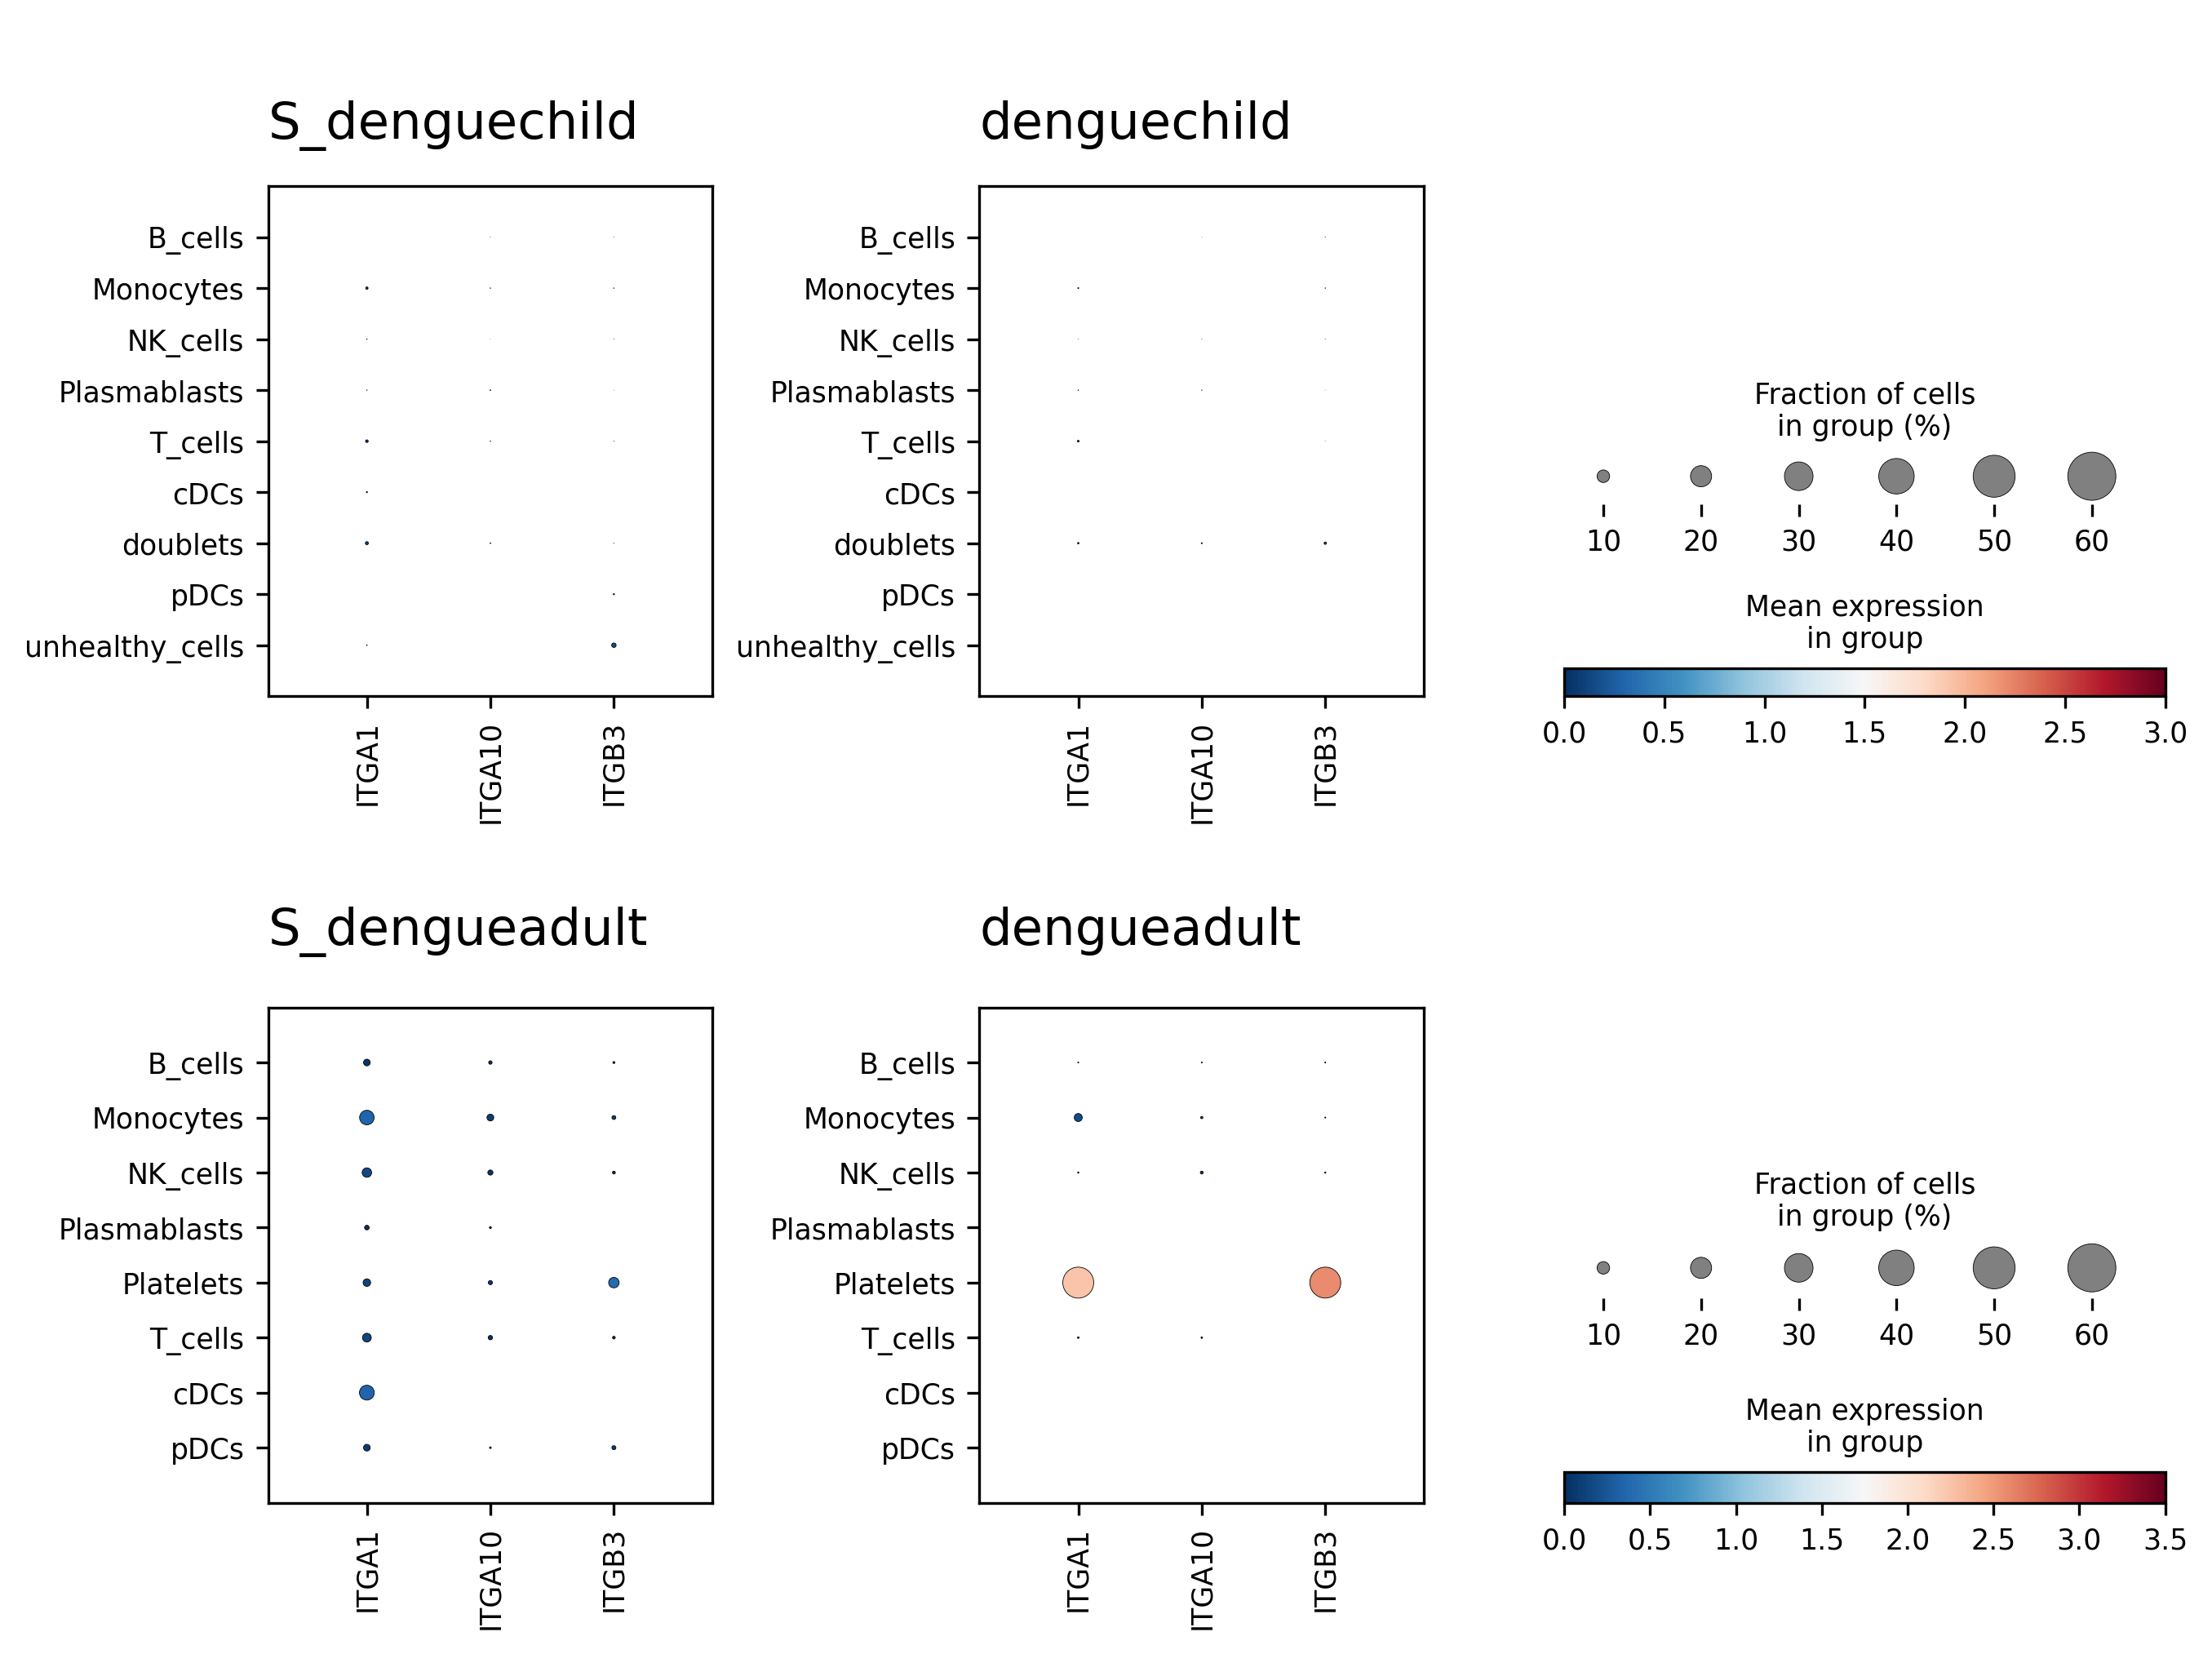

In [49]:
inters = [ 'ITGA1', 'ITGA10', 'ITGB3']
S_dengue_vs_dengue(adata, 'S_dengue', 'dengue', 'cell_type', inters)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  w

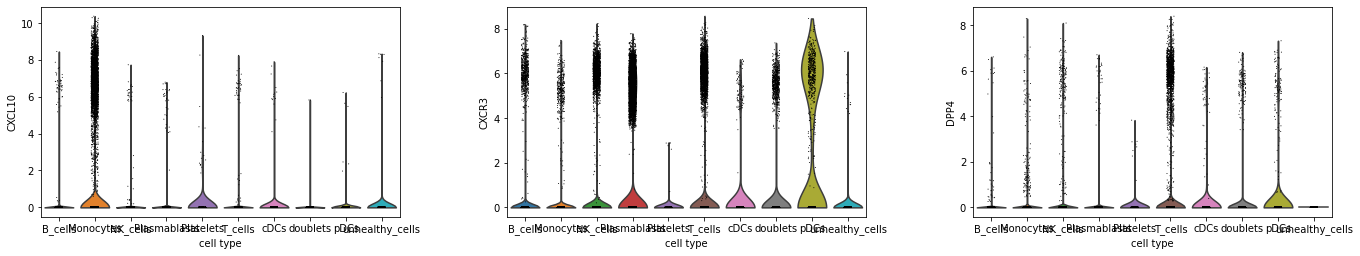

In [50]:
inters = [ 'CXCL10', 'CXCR3', 'DPP4']
#fig, ax = plt.subplots(figsize=[15,5])
sc.pl.violin(adata, inters, groupby = 'cell_type', figsize=[15,5])

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1207: ImplicitModificationWarning: Initializing view as actual.
  warnings.warn(
Trying to set attribute `.obs` of view, copying.
... storing 'dataset' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sick' as categorical
<ipython-input-18-4ea1638a0a0d>:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


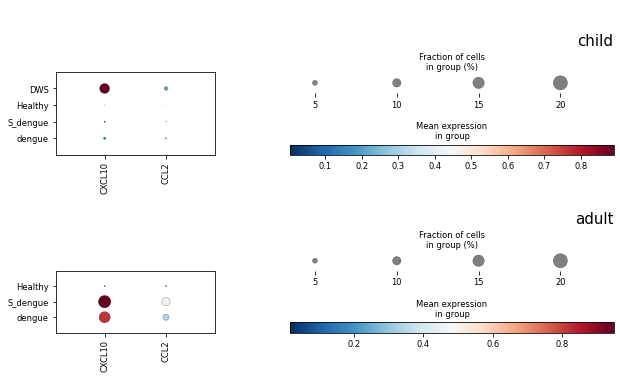

In [18]:
inters = ['CXCL10', 'CCL2']

adata
fig,axs = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'wspace':0.1}, sharex=True, facecolor='white')
ax=axs[0]
sc.pl.dotplot(adata_children, inters, groupby='Condition', ax=ax, show=False, cmap='RdBu_r')
ax.set_title('child', fontsize=15, y=0.7, loc='right')
ax=axs[1]
sc.pl.dotplot(adata_adults, inters, groupby='Condition', ax=ax, show=False, cmap='RdBu_r')
ax.set_title('adult', fontsize=15, y=0.7, loc='right')
plt.tight_layout()

<ipython-input-16-8f51dd58c137>:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


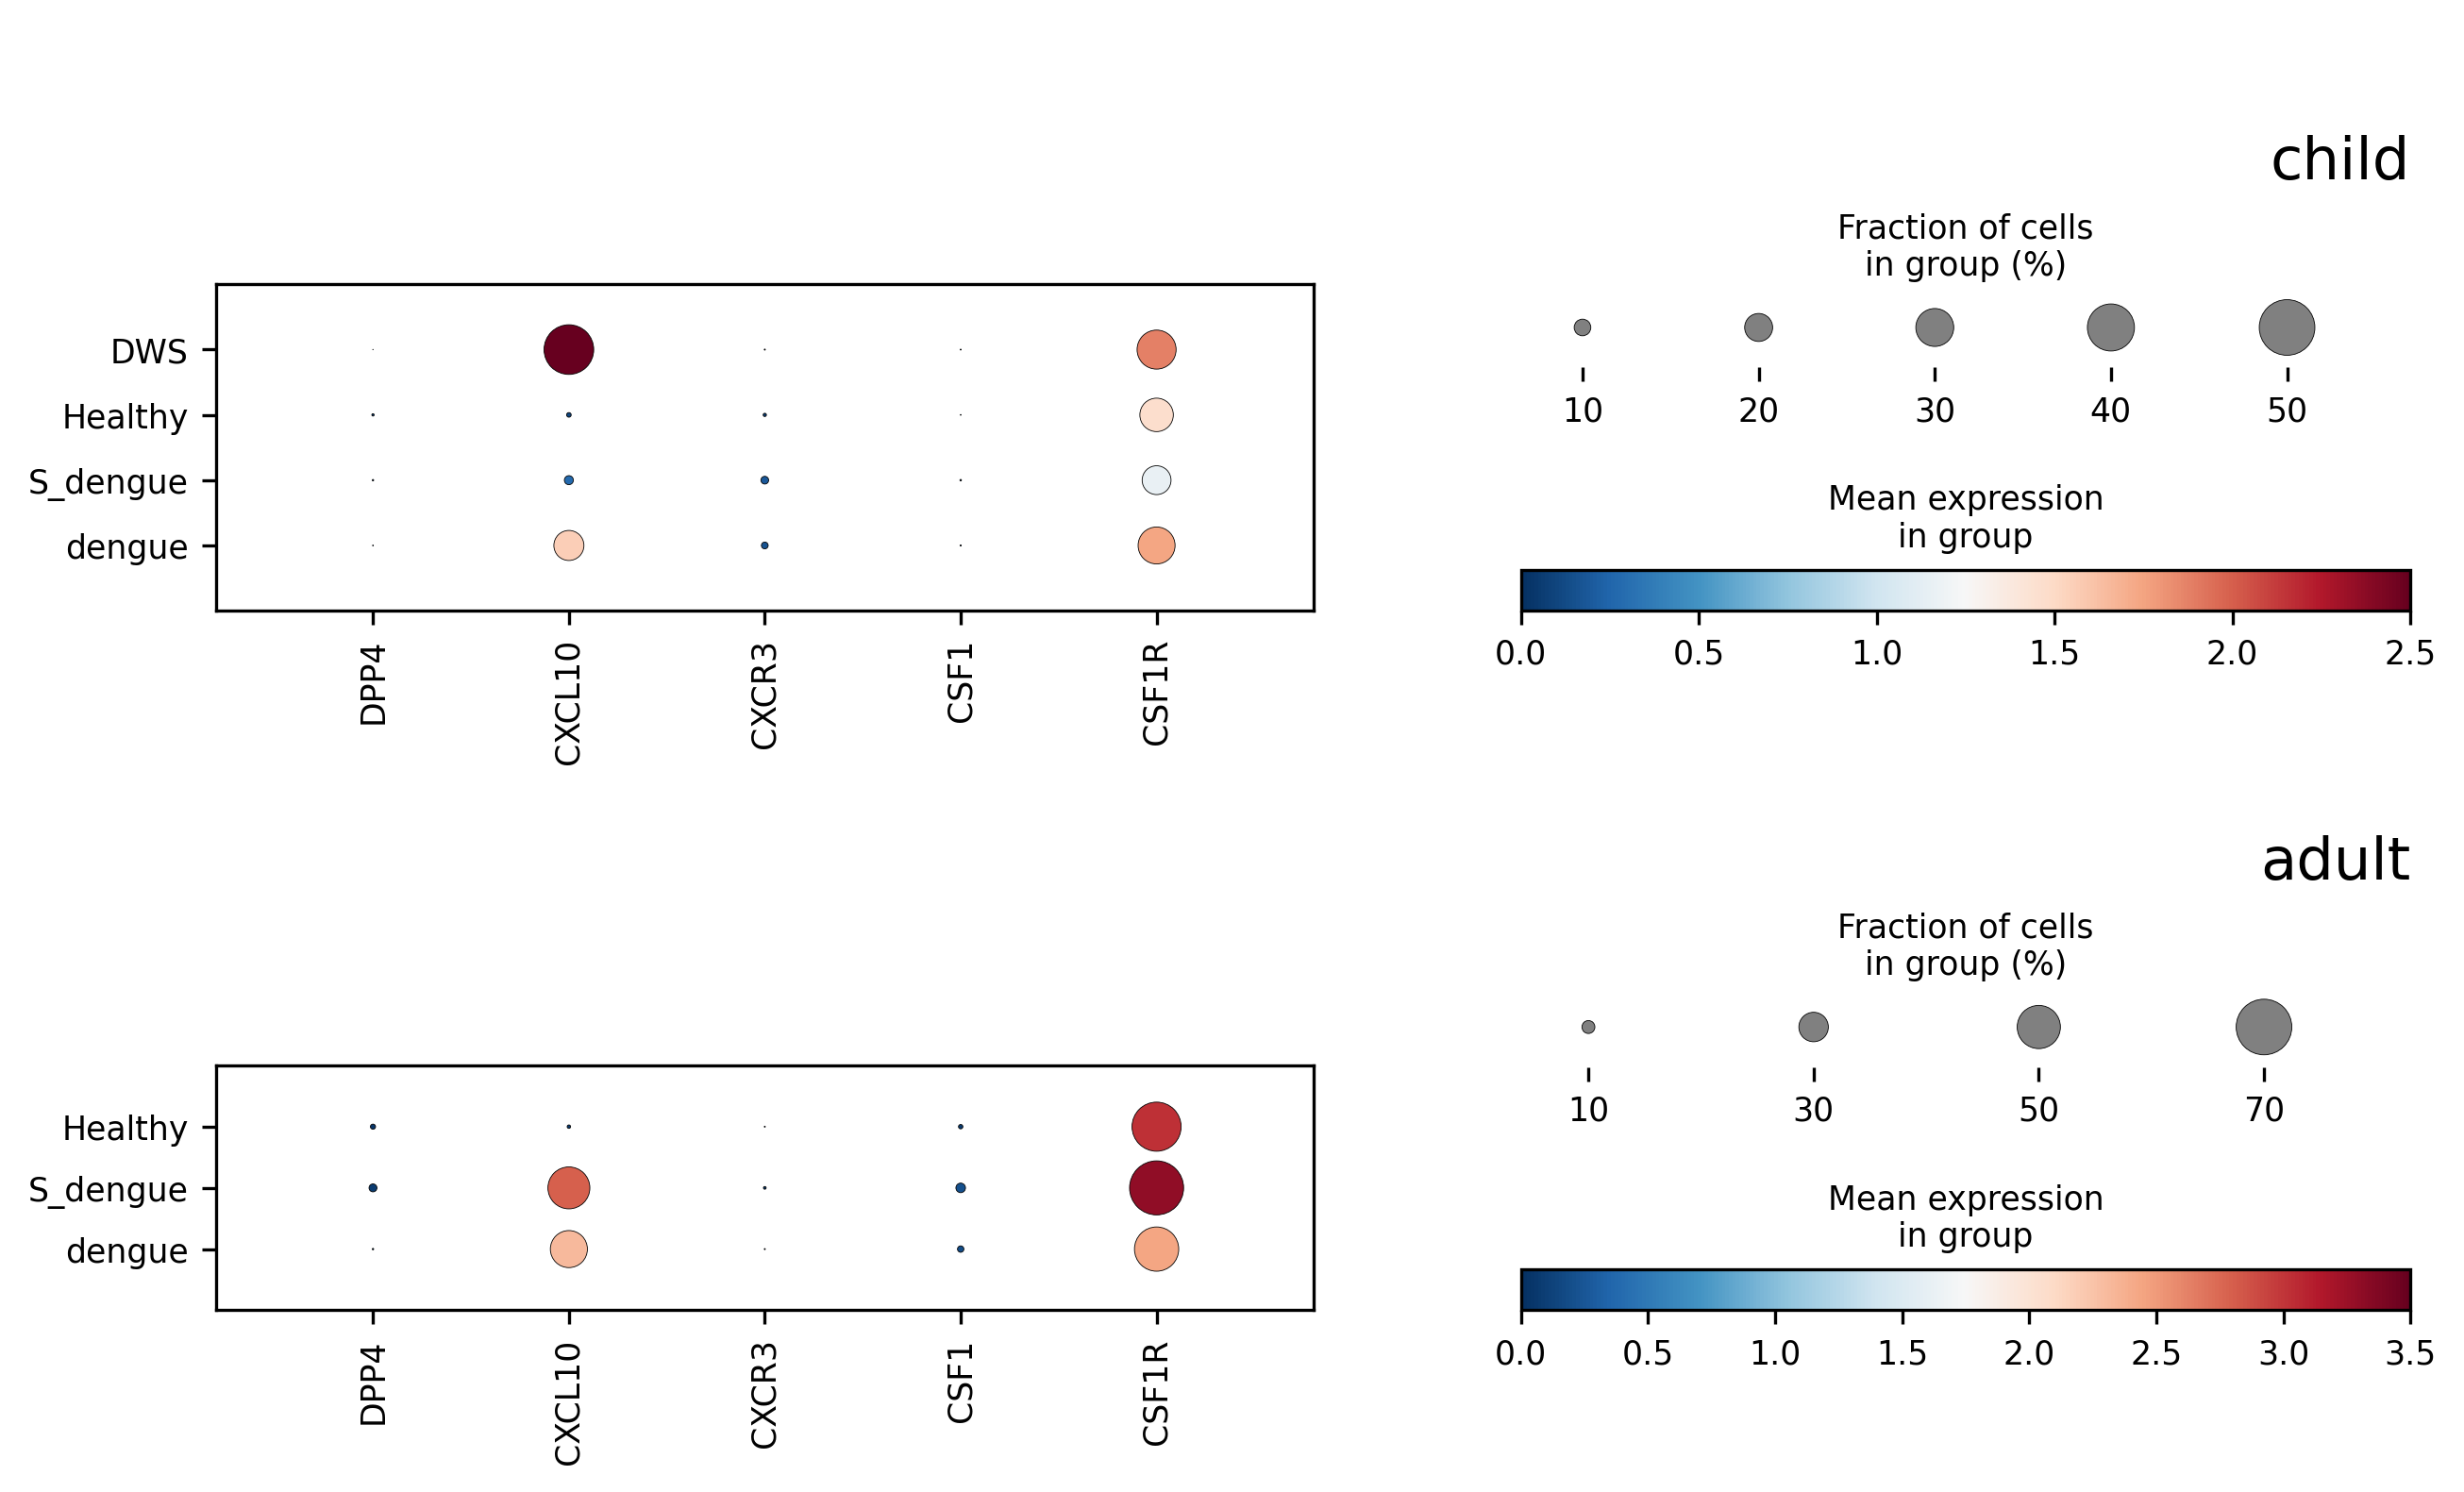

In [16]:
inters = [#'ITGA1', 'ITGA2', 'IFNG', 'SEMA7A', 
          'DPP4', 'CXCL10', 'CXCR3', 'CSF1', 'CSF1R',
         ]

fig,axs = plt.subplots(2, 1, figsize=(10,6), gridspec_kw={'wspace':0.1}, sharex=True, dpi=300, facecolor='white')
ax=axs[0]
sc.pl.dotplot(adata_dic[('Monocytes', 'child')], inters, groupby='Condition', ax=ax, show=False, cmap='RdBu_r', vmin=0, vmax=2.5)
ax.set_title('child', fontsize=15, y=0.7, loc='right')
ax=axs[1]
sc.pl.dotplot(adata_dic[('Monocytes', 'adult')], inters, groupby='Condition', ax=ax, show=False, cmap='RdBu_r', vmin=0, vmax=3.5)
ax.set_title('adult', fontsize=15, y=0.7, loc='right')
plt.tight_layout()